## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
from openpyxl.utils import get_column_letter
import json

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-7
EPOCHS = 50
T = 10

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Data Loading

In [3]:
def load_data(*file_paths):
    """
    Returns:
        X (numpy.ndarray): Features array
        y (numpy.ndarray): Labels array
    """
    
    if len(file_paths) == 1:  # Single .npz file
        file_path = file_paths[0]
        
        if not file_path.endswith(".npz"):
            raise ValueError("Single input must be a .npz file")
            
        with np.load(file_path) as data:
            X = data["X"]
            y = data["y"]

    elif len(file_paths) == 2:  # Two .npy files
        x_path, y_path = file_paths
        
        if not (x_path.endswith(".npy") and y_path.endswith(".npy")):
            raise ValueError("When providing two inputs, both must be .npy files")
            
        X = np.load(x_path)
        y = np.load(y_path)

    return X, y

## Checking Distributions

In [4]:
def plot_input_dist(X):
    X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()
    
    for i in range(6):
        axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
        axs[i].set_title(f'Channel {i+1}')
    plt.tight_layout()
    plt.show()


def plot_label_dist(y):
    # Checking the label distribution of training data
    print('\n\n====== Label Distribution ======')
    unique_labels, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
    print("-" * 30)
    for label, count in zip(unique_labels, counts):
        percentage = (count / total) * 100
        print(f"{label:<10}{count:<10}{percentage:<.2f}%")
    
    print(f"\nTotal samples: {total}")
    
    # Plot histogram for training data
    unique_labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 4))
    plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(f"Label Distribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Input Preprocessing

In [5]:
def normalize(X):
    # Standardizing the input features across all timesteps and samples using Z-scores
    # Compute per-feature mean and std across all samples and timesteps
    feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
    feature_stds = X.std(axis=(0, 1))    # Shape: (6,)
    
    # Reshape for broadcasting
    feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
    feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)
    
    # Standardize
    X = ((X - feature_means) / feature_stds).astype(np.float32)
    return X

## Dataset Class

In [6]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Model

In [7]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)
        self.dropout = nn.Dropout(p=0.3)

In [8]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

## Evaluation

In [9]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [10]:
def evaluate(model, dataloader, class_weights=None, T=T, device=DEVICE):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0
    val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, kl = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Loss Calculation
            nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            loss = nll + KL_WEIGHT * kl
            val_loss += loss.item() * x_batch.size(0)
            

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    val_loss /= len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return val_loss, acc, kappa, per_class_f1, avg_f1, cm

## Training

In [11]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [12]:
def train(model, train_dataset, train_dataloader, val_dataset, val_dataloader, class_weights=None, EPOCHS=EPOCHS, T=T):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s, val_per_class_f1s, val_kappas = [], [], []

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss, val_acc, kappa, per_class_f1, avg_f1, _ = evaluate(
            model, val_dataloader, class_weights=class_weights, T=T, device=DEVICE
        )

        scheduler.step(val_loss)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_kappas.append(kappa)
        val_f1s.append(avg_f1)
        val_per_class_f1s.append(per_class_f1)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"F1: {avg_f1:.4f}, Kappa: {kappa:.4f}")  

    return train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s

## Plotting

In [13]:
def plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS):
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(18, 5))  

    # --- Plot Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Validation F1 ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1s, label='Val F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Saving Results

In [14]:
def save_results(output_file, history):
    # ensure .xlsx extension
    if not output_file.lower().endswith(".xlsx"):
        output_file = output_file + ".xlsx"

    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for file_name, h in history.items():
            # ---------------------------
            # Per-epoch logs
            # ---------------------------
            df_epochs = pd.DataFrame({
                "epoch": list(range(1, len(h["train_loss"]) + 1)),
                "train_loss": h["train_loss"],
                "train_acc": h["train_acc"],
                "val_loss": h["val_loss"],
                "val_acc": h["val_acc"],
                "val_f1": h["val_f1s"],
                "val_kappa": h["val_kappas"],
                "val_per_class_f1": [
                    ",".join(map(str, f1s)) if f1s is not None else None 
                    for f1s in h["val_per_class_f1s"]
                ]
            })

            # ---------------------------
            # Final test metrics
            # ---------------------------
            final_metrics = {
                "metric": [
                    "overall_loss",
                    "overall_acc",
                    "kappa",
                    "avg_f1",
                    "per_class_f1",
                    "cm"
                ],
                "value": [
                    h["overall_loss"],
                    h["overall_acc"],
                    h["kappa"],
                    h["avg_f1"],
                    ",".join(map(str, h["per_class_f1"])) if h["per_class_f1"] is not None else None,
                    str(h["cm"]) if h["cm"] is not None else None
                ]
            }
            df_final = pd.DataFrame(final_metrics)

            # ---------------------------
            # Write to Excel
            # ---------------------------
            sheet_name = os.path.basename(file_name)[:31]  # Excel sheet name max length = 31
            df_epochs.to_excel(writer, sheet_name=sheet_name, index=False, startrow=0)
            startrow = len(df_epochs) + 2
            df_final.to_excel(writer, sheet_name=sheet_name, index=False, startrow=startrow)

        # ---------------------------
        # Auto-adjust column widths
        # ---------------------------
        for sheet_name, worksheet in writer.sheets.items():
            for col_idx, col_cells in enumerate(worksheet.columns, 1):
                max_length = 0
                col_letter = get_column_letter(col_idx)
                for cell in col_cells:
                    try:
                        if cell.value:
                            max_length = max(max_length, len(str(cell.value)))
                    except:
                        pass
                worksheet.column_dimensions[col_letter].width = max_length + 2

    print(f"Saved history of all files to {output_file}")

In [15]:
def save_history(history, name, output_dir="/kaggle/working"):
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (set, tuple)):
            return list(obj)
        return obj

    # Remove ".npz" if present
    base_name = os.path.basename(name).replace(".npz", "")
    output_file = os.path.join(output_dir, f"{base_name}_history.json")

    with open(output_file, "w") as f:
        json.dump(history, f, default=convert, indent=4)

    print(f'History Dumped in file {output_file}')

## Start

In [ ]:
data_dir = "/kaggle/input/data-al"
file_names = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")])
# file_names = file_names[9:]
for name in file_names:
    print(name)
    
X_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy'
y_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy'

/kaggle/input/data-al/true_BCNN_data_bald.npz
/kaggle/input/data-al/true_BCNN_data_bvsb.npz
/kaggle/input/data-al/true_BCNN_data_predictive_entropy.npz
/kaggle/input/data-al/true_BCNN_data_variation_ratio.npz


In [17]:
history = {}

for name in file_names:
    history[name] = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [], 
        'val_acc': [],
        'val_f1s': [],
        'val_kappas': [],
        'val_per_class_f1s': [],
        
        'overall_loss': None,
        'overall_acc': None,
        'kappa': None,
        'avg_f1': None,
        'per_class_f1': None,
        'cm': None
    }



====== Loading Data /kaggle/input/data-al/true_BCNN_data_bald.npz ======
Train Data:  (14000, 28, 6) (14000,)


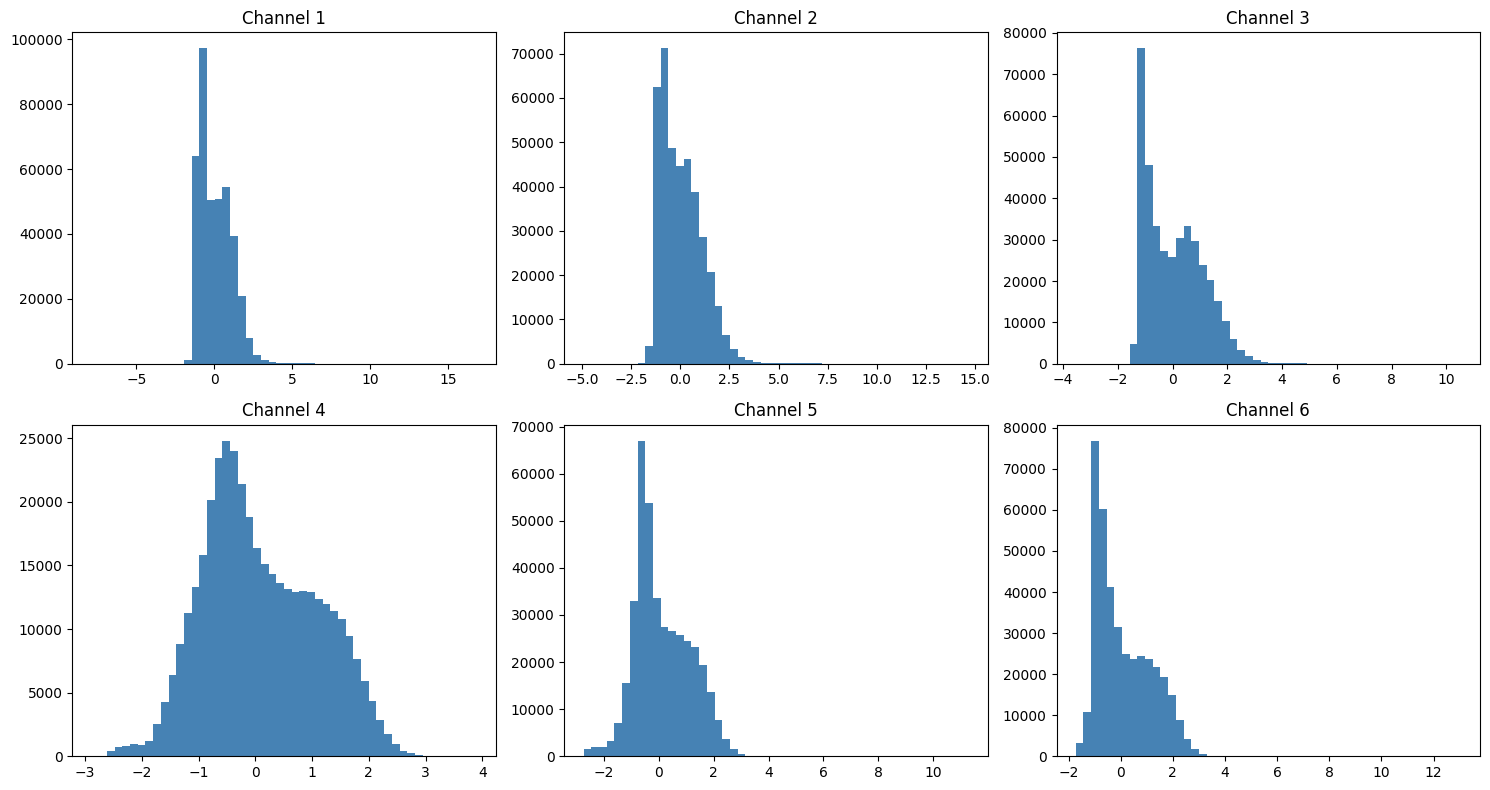

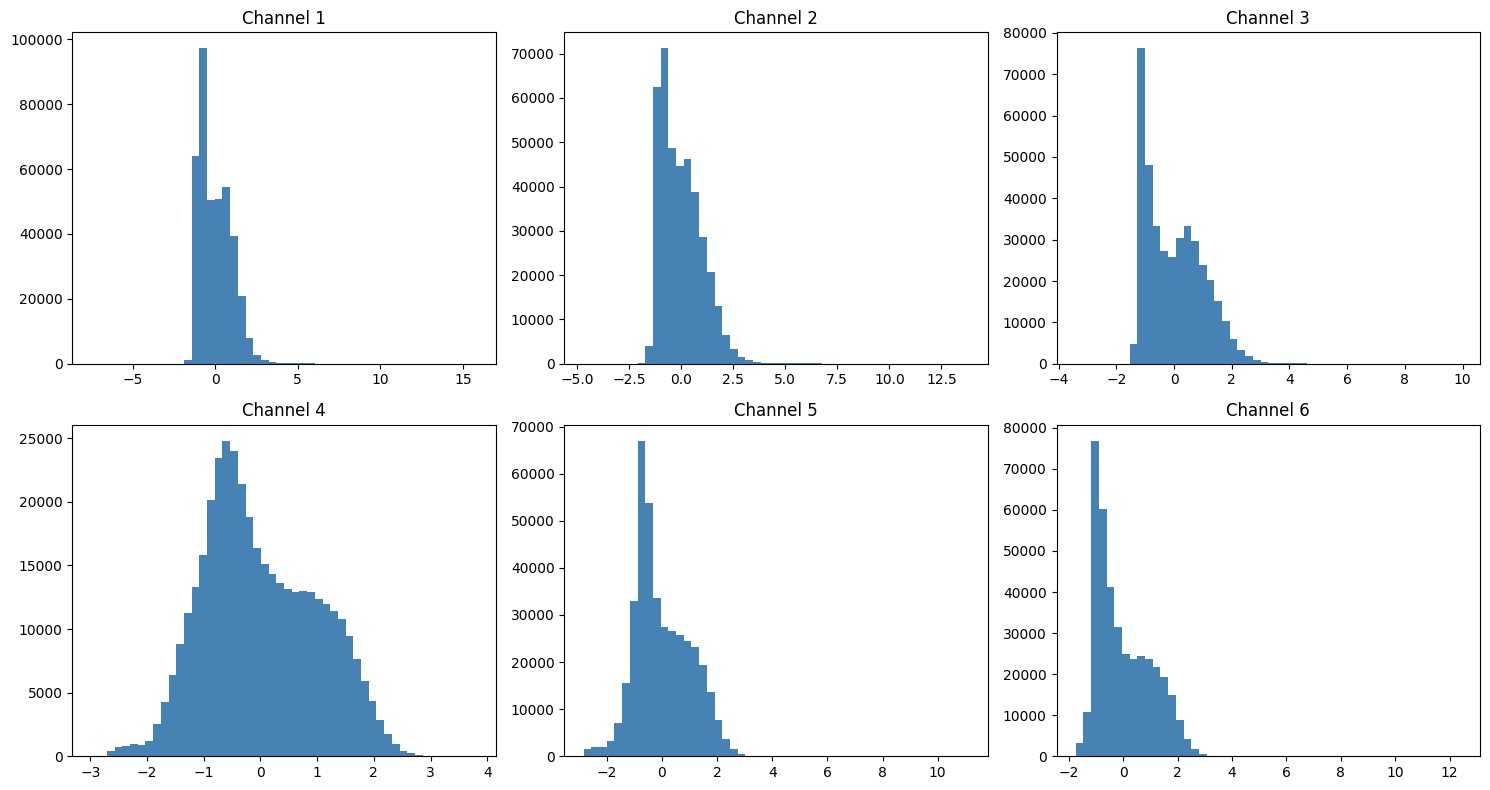



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         5593      39.95%
1         1435      10.25%
2         6972      49.80%

Total samples: 14000


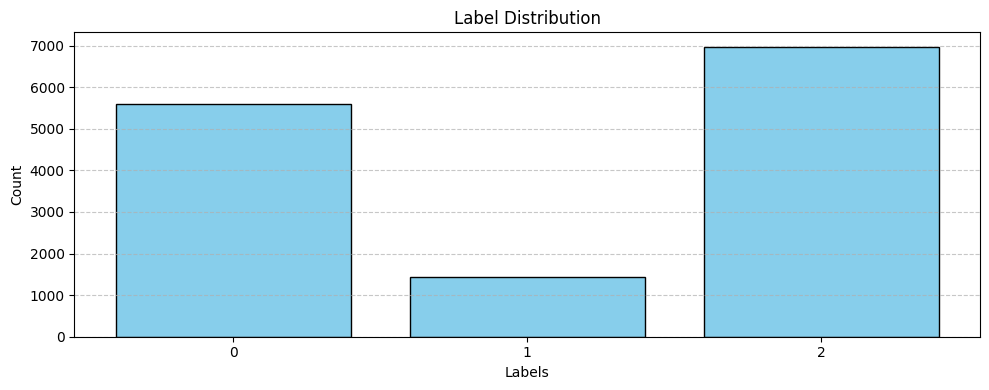


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


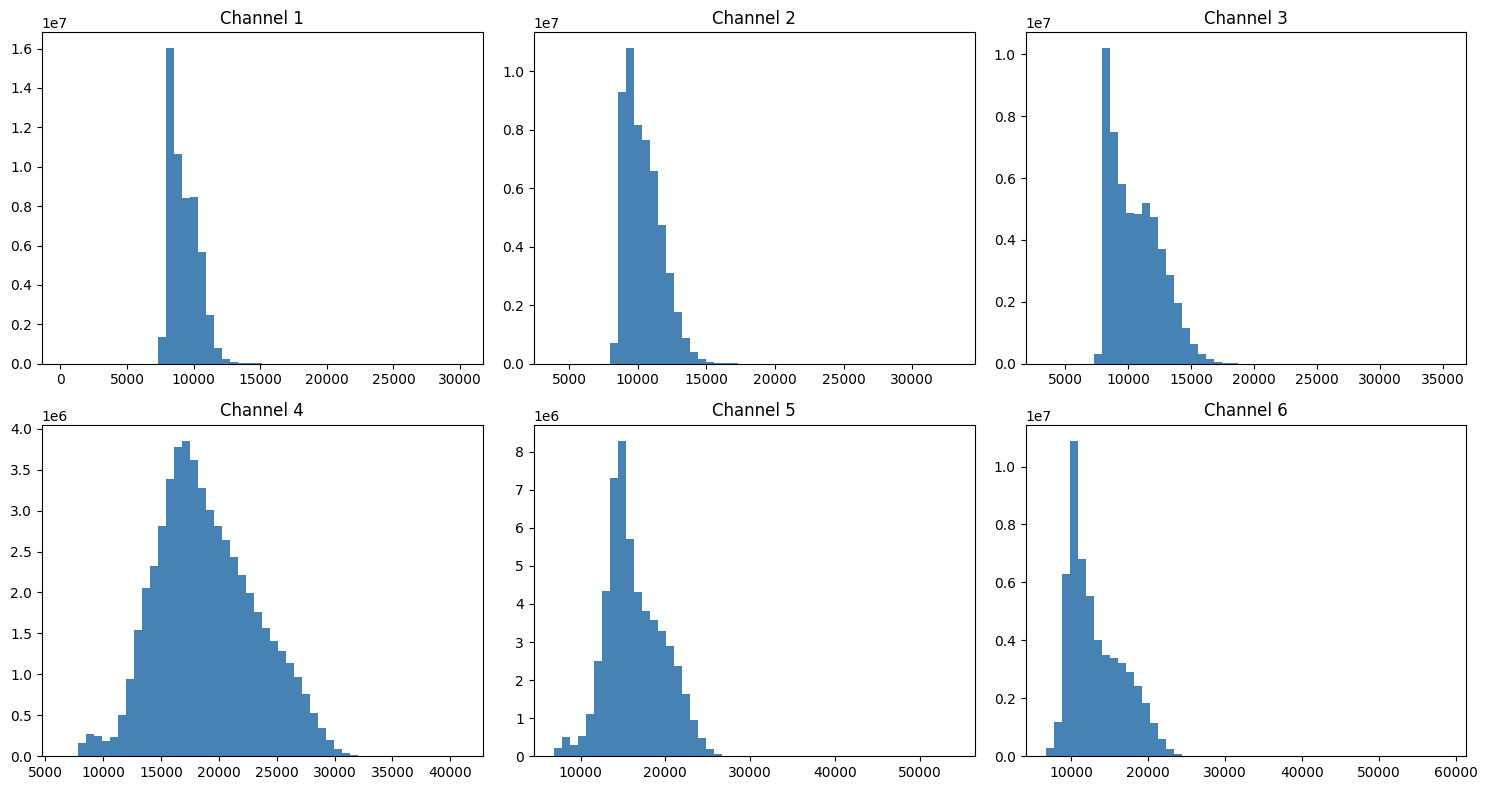

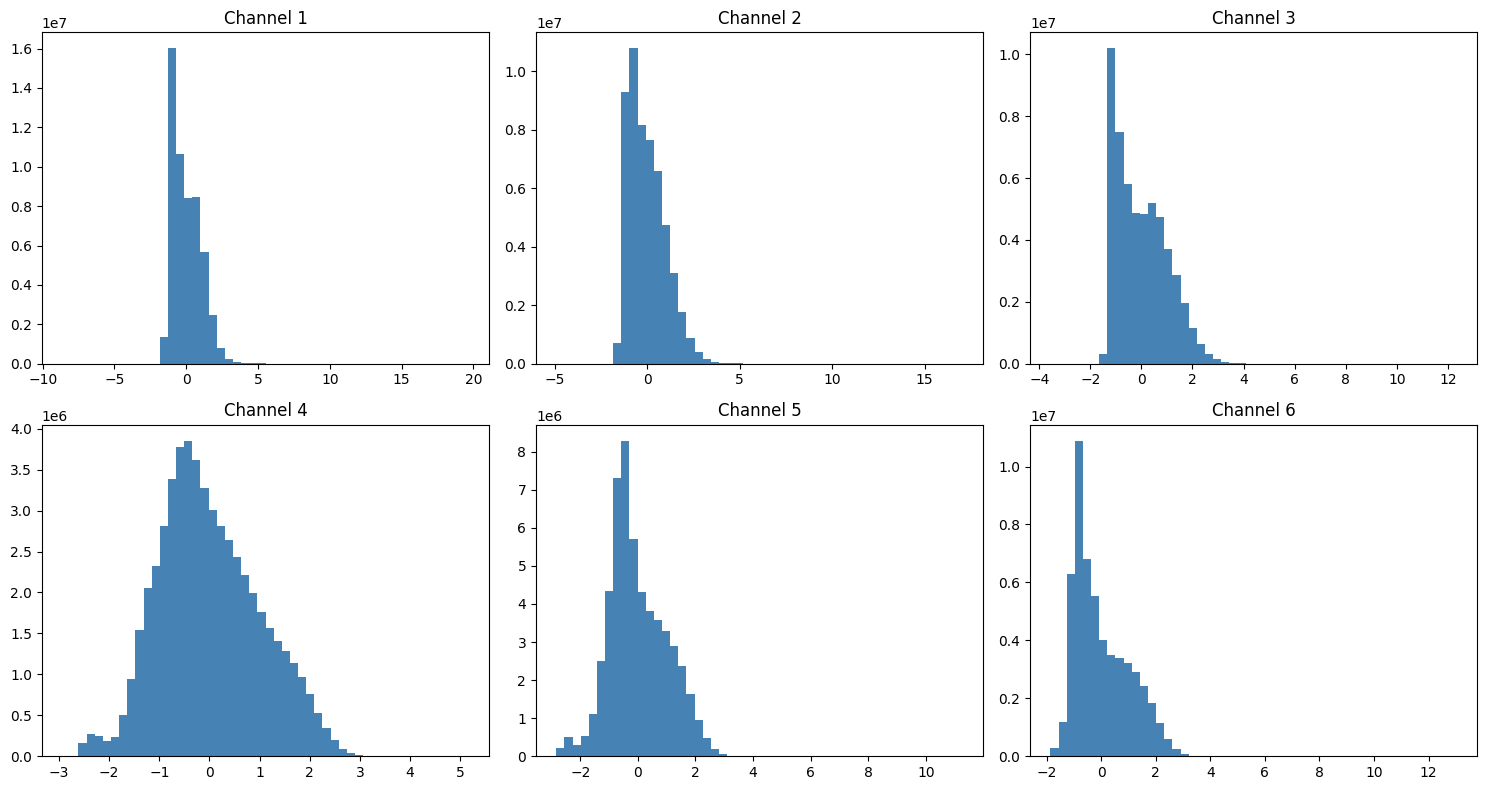



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


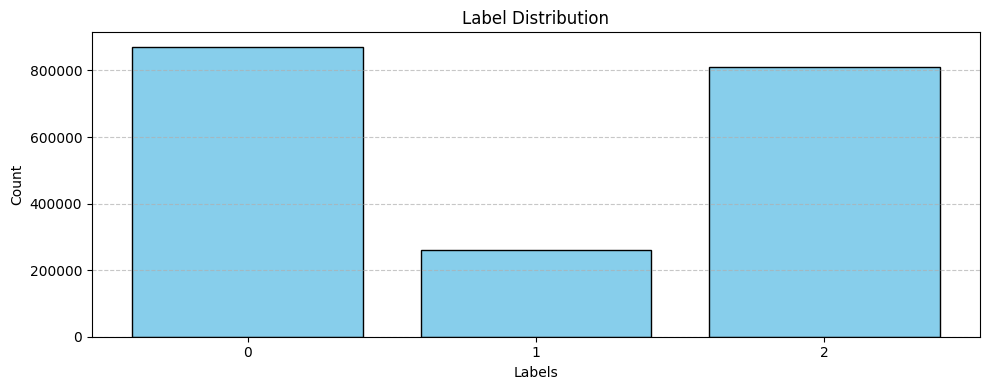

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.8344, 3.2520, 0.6693], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 39.78it/s]


Loss: 0.6681 + 1e-07 * 2702691.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.16it/s]


Epoch [1/50] Train Loss: 1.2619, Train Acc: 0.5545 | Val Loss: 0.6876, Val Acc: 0.7923, F1: 0.8016, Kappa: 0.6630


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.6421 + 1e-07 * 2523282.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.94it/s]


Epoch [2/50] Train Loss: 0.9930, Train Acc: 0.6155 | Val Loss: 0.6101, Val Acc: 0.8421, F1: 0.8449, Kappa: 0.7427


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.52it/s]


Loss: 0.5826 + 1e-07 * 2351817.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.97it/s]


Epoch [3/50] Train Loss: 0.9297, Train Acc: 0.6371 | Val Loss: 0.5598, Val Acc: 0.8614, F1: 0.8601, Kappa: 0.7746


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.6529 + 1e-07 * 2196478.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.03it/s]


Epoch [4/50] Train Loss: 0.8922, Train Acc: 0.6529 | Val Loss: 0.5287, Val Acc: 0.8668, F1: 0.8648, Kappa: 0.7830


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.88it/s]


Loss: 0.6081 + 1e-07 * 2056984.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.16it/s]


Epoch [5/50] Train Loss: 0.8562, Train Acc: 0.6631 | Val Loss: 0.5076, Val Acc: 0.8615, F1: 0.8618, Kappa: 0.7745


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.50it/s]


Loss: 0.5268 + 1e-07 * 1929515.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.81it/s]


Epoch [6/50] Train Loss: 0.8228, Train Acc: 0.6774 | Val Loss: 0.4815, Val Acc: 0.8763, F1: 0.8760, Kappa: 0.7979


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.80it/s]


Loss: 0.8453 + 1e-07 * 1819989.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.04it/s]


Epoch [7/50] Train Loss: 0.7933, Train Acc: 0.6880 | Val Loss: 0.4703, Val Acc: 0.8677, F1: 0.8631, Kappa: 0.7855


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.6385 + 1e-07 * 1720742.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.28it/s]


Epoch [8/50] Train Loss: 0.7806, Train Acc: 0.6931 | Val Loss: 0.4584, Val Acc: 0.8724, F1: 0.8722, Kappa: 0.7915


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.6489 + 1e-07 * 1631691.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.00it/s]


Epoch [9/50] Train Loss: 0.7523, Train Acc: 0.6980 | Val Loss: 0.4344, Val Acc: 0.8770, F1: 0.8745, Kappa: 0.7999


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.5124 + 1e-07 * 1554661.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.01it/s]


Epoch [10/50] Train Loss: 0.7469, Train Acc: 0.7001 | Val Loss: 0.4258, Val Acc: 0.8766, F1: 0.8732, Kappa: 0.7992


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.4165 + 1e-07 * 1484721.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.47it/s]


Epoch [11/50] Train Loss: 0.7326, Train Acc: 0.7041 | Val Loss: 0.4223, Val Acc: 0.8660, F1: 0.8594, Kappa: 0.7836


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.4855 + 1e-07 * 1424121.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.08it/s]


Epoch [12/50] Train Loss: 0.7179, Train Acc: 0.7125 | Val Loss: 0.4062, Val Acc: 0.8775, F1: 0.8743, Kappa: 0.8004


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.90it/s]


Loss: 0.6145 + 1e-07 * 1365905.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.28it/s]


Epoch [13/50] Train Loss: 0.7116, Train Acc: 0.7145 | Val Loss: 0.3951, Val Acc: 0.8819, F1: 0.8784, Kappa: 0.8075


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.78it/s]


Loss: 0.4063 + 1e-07 * 1312456.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.80it/s]


Epoch [14/50] Train Loss: 0.6786, Train Acc: 0.7216 | Val Loss: 0.4002, Val Acc: 0.8755, F1: 0.8747, Kappa: 0.7971


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.4257 + 1e-07 * 1268018.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.64it/s]


Epoch [15/50] Train Loss: 0.6842, Train Acc: 0.7165 | Val Loss: 0.3826, Val Acc: 0.8845, F1: 0.8846, Kappa: 0.8108


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.78it/s]


Loss: 0.5630 + 1e-07 * 1226455.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.21it/s]


Epoch [16/50] Train Loss: 0.6721, Train Acc: 0.7233 | Val Loss: 0.3732, Val Acc: 0.8836, F1: 0.8814, Kappa: 0.8100


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.96it/s]


Loss: 0.4333 + 1e-07 * 1187875.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.00it/s]


Epoch [17/50] Train Loss: 0.6723, Train Acc: 0.7204 | Val Loss: 0.3755, Val Acc: 0.8767, F1: 0.8729, Kappa: 0.7994


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 43.01it/s]


Loss: 0.6184 + 1e-07 * 1152885.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.52it/s]


Epoch [18/50] Train Loss: 0.6609, Train Acc: 0.7246 | Val Loss: 0.3678, Val Acc: 0.8813, F1: 0.8785, Kappa: 0.8066


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.4457 + 1e-07 * 1119900.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.64it/s]


Epoch [19/50] Train Loss: 0.6496, Train Acc: 0.7238 | Val Loss: 0.3707, Val Acc: 0.8728, F1: 0.8616, Kappa: 0.7954


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.62it/s]


Loss: 0.4314 + 1e-07 * 1090802.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.35it/s]


Epoch [20/50] Train Loss: 0.6519, Train Acc: 0.7284 | Val Loss: 0.3526, Val Acc: 0.8864, F1: 0.8836, Kappa: 0.8147


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.5327 + 1e-07 * 1062957.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.80it/s]


Epoch [21/50] Train Loss: 0.6440, Train Acc: 0.7327 | Val Loss: 0.3698, Val Acc: 0.8764, F1: 0.8758, Kappa: 0.7985


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.4810 + 1e-07 * 1039799.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.05it/s]


Epoch [22/50] Train Loss: 0.6284, Train Acc: 0.7336 | Val Loss: 0.3561, Val Acc: 0.8855, F1: 0.8849, Kappa: 0.8126


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.7132 + 1e-07 * 1016847.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.72it/s]


Epoch [23/50] Train Loss: 0.6267, Train Acc: 0.7325 | Val Loss: 0.3429, Val Acc: 0.8873, F1: 0.8839, Kappa: 0.8163


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.5872 + 1e-07 * 995368.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.11it/s]


Epoch [24/50] Train Loss: 0.6203, Train Acc: 0.7349 | Val Loss: 0.3520, Val Acc: 0.8795, F1: 0.8778, Kappa: 0.8037


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.6101 + 1e-07 * 976030.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.92it/s]


Epoch [25/50] Train Loss: 0.6266, Train Acc: 0.7279 | Val Loss: 0.3352, Val Acc: 0.8910, F1: 0.8879, Kappa: 0.8223


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.3750 + 1e-07 * 957856.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.97it/s]


Epoch [26/50] Train Loss: 0.6127, Train Acc: 0.7361 | Val Loss: 0.3393, Val Acc: 0.8905, F1: 0.8851, Kappa: 0.8218


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.7649 + 1e-07 * 942042.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.69it/s]


Epoch [27/50] Train Loss: 0.6052, Train Acc: 0.7395 | Val Loss: 0.3484, Val Acc: 0.8812, F1: 0.8802, Kappa: 0.8063


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 42.69it/s]


Loss: 0.3881 + 1e-07 * 929453.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.58it/s]


Epoch [28/50] Train Loss: 0.6119, Train Acc: 0.7326 | Val Loss: 0.3433, Val Acc: 0.8863, F1: 0.8845, Kappa: 0.8143


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 43.06it/s]


Loss: 0.5287 + 1e-07 * 915949.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.43it/s]


Epoch [29/50] Train Loss: 0.6020, Train Acc: 0.7379 | Val Loss: 0.3308, Val Acc: 0.8895, F1: 0.8867, Kappa: 0.8196


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.73it/s]


Loss: 0.4632 + 1e-07 * 901624.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.12it/s]


Epoch [30/50] Train Loss: 0.5948, Train Acc: 0.7441 | Val Loss: 0.3353, Val Acc: 0.8880, F1: 0.8829, Kappa: 0.8178


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.6747 + 1e-07 * 887935.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.03it/s]


Epoch [31/50] Train Loss: 0.5864, Train Acc: 0.7419 | Val Loss: 0.3470, Val Acc: 0.8861, F1: 0.8862, Kappa: 0.8136


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.5516 + 1e-07 * 876863.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.41it/s]


Epoch [32/50] Train Loss: 0.5970, Train Acc: 0.7414 | Val Loss: 0.3340, Val Acc: 0.8889, F1: 0.8873, Kappa: 0.8183


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.46it/s]


Loss: 0.6242 + 1e-07 * 864479.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.49it/s]


Epoch [33/50] Train Loss: 0.5836, Train Acc: 0.7469 | Val Loss: 0.3394, Val Acc: 0.8904, F1: 0.8887, Kappa: 0.8208


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.5293 + 1e-07 * 855359.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.16it/s]


Epoch [34/50] Train Loss: 0.5855, Train Acc: 0.7476 | Val Loss: 0.3331, Val Acc: 0.8933, F1: 0.8955, Kappa: 0.8246


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.75it/s]


Loss: 0.5681 + 1e-07 * 845473.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.73it/s]


Epoch [35/50] Train Loss: 0.5868, Train Acc: 0.7481 | Val Loss: 0.3318, Val Acc: 0.8810, F1: 0.8734, Kappa: 0.8070


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.5190 + 1e-07 * 836433.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.44it/s]


Epoch [36/50] Train Loss: 0.5723, Train Acc: 0.7543 | Val Loss: 0.3286, Val Acc: 0.8907, F1: 0.8895, Kappa: 0.8213


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.56it/s]


Loss: 0.3707 + 1e-07 * 828444.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.34it/s]


Epoch [37/50] Train Loss: 0.5561, Train Acc: 0.7579 | Val Loss: 0.3268, Val Acc: 0.8943, F1: 0.8933, Kappa: 0.8273


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.4592 + 1e-07 * 821320.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.64it/s]


Epoch [38/50] Train Loss: 0.5634, Train Acc: 0.7546 | Val Loss: 0.3229, Val Acc: 0.8960, F1: 0.8950, Kappa: 0.8297


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.5745 + 1e-07 * 814463.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.69it/s]


Epoch [39/50] Train Loss: 0.5635, Train Acc: 0.7561 | Val Loss: 0.3341, Val Acc: 0.8876, F1: 0.8882, Kappa: 0.8161


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.78it/s]


Loss: 0.4882 + 1e-07 * 808076.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.24it/s]


Epoch [40/50] Train Loss: 0.5568, Train Acc: 0.7559 | Val Loss: 0.3217, Val Acc: 0.8933, F1: 0.8922, Kappa: 0.8255


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.4675 + 1e-07 * 802017.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.75it/s]


Epoch [41/50] Train Loss: 0.5542, Train Acc: 0.7589 | Val Loss: 0.3239, Val Acc: 0.8935, F1: 0.8921, Kappa: 0.8258


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 42.73it/s]


Loss: 0.5084 + 1e-07 * 796330.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.36it/s]


Epoch [42/50] Train Loss: 0.5556, Train Acc: 0.7604 | Val Loss: 0.3149, Val Acc: 0.8945, F1: 0.8923, Kappa: 0.8277


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.86it/s]


Loss: 0.4409 + 1e-07 * 790791.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.61it/s]


Epoch [43/50] Train Loss: 0.5450, Train Acc: 0.7577 | Val Loss: 0.3222, Val Acc: 0.8966, F1: 0.8962, Kappa: 0.8303


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.6412 + 1e-07 * 785271.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.09it/s]


Epoch [44/50] Train Loss: 0.5507, Train Acc: 0.7573 | Val Loss: 0.3254, Val Acc: 0.8920, F1: 0.8919, Kappa: 0.8229


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.3856 + 1e-07 * 780361.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.13it/s]


Epoch [45/50] Train Loss: 0.5414, Train Acc: 0.7628 | Val Loss: 0.3208, Val Acc: 0.8939, F1: 0.8933, Kappa: 0.8262


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.5174 + 1e-07 * 775937.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.42it/s]


Epoch [46/50] Train Loss: 0.5429, Train Acc: 0.7616 | Val Loss: 0.3296, Val Acc: 0.8887, F1: 0.8859, Kappa: 0.8183


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.4326 + 1e-07 * 771797.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.91it/s]


Epoch [47/50] Train Loss: 0.5499, Train Acc: 0.7609 | Val Loss: 0.3235, Val Acc: 0.8918, F1: 0.8896, Kappa: 0.8229


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.5938 + 1e-07 * 767623.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.37it/s]


Epoch [48/50] Train Loss: 0.5353, Train Acc: 0.7651 | Val Loss: 0.3118, Val Acc: 0.8951, F1: 0.8917, Kappa: 0.8286


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.65it/s]


Loss: 0.5224 + 1e-07 * 763286.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.37it/s]


Epoch [49/50] Train Loss: 0.5417, Train Acc: 0.7637 | Val Loss: 0.3187, Val Acc: 0.8951, F1: 0.8951, Kappa: 0.8280


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.4750 + 1e-07 * 759329.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.45it/s]


Epoch [50/50] Train Loss: 0.5451, Train Acc: 0.7624 | Val Loss: 0.3199, Val Acc: 0.8919, F1: 0.8912, Kappa: 0.8231


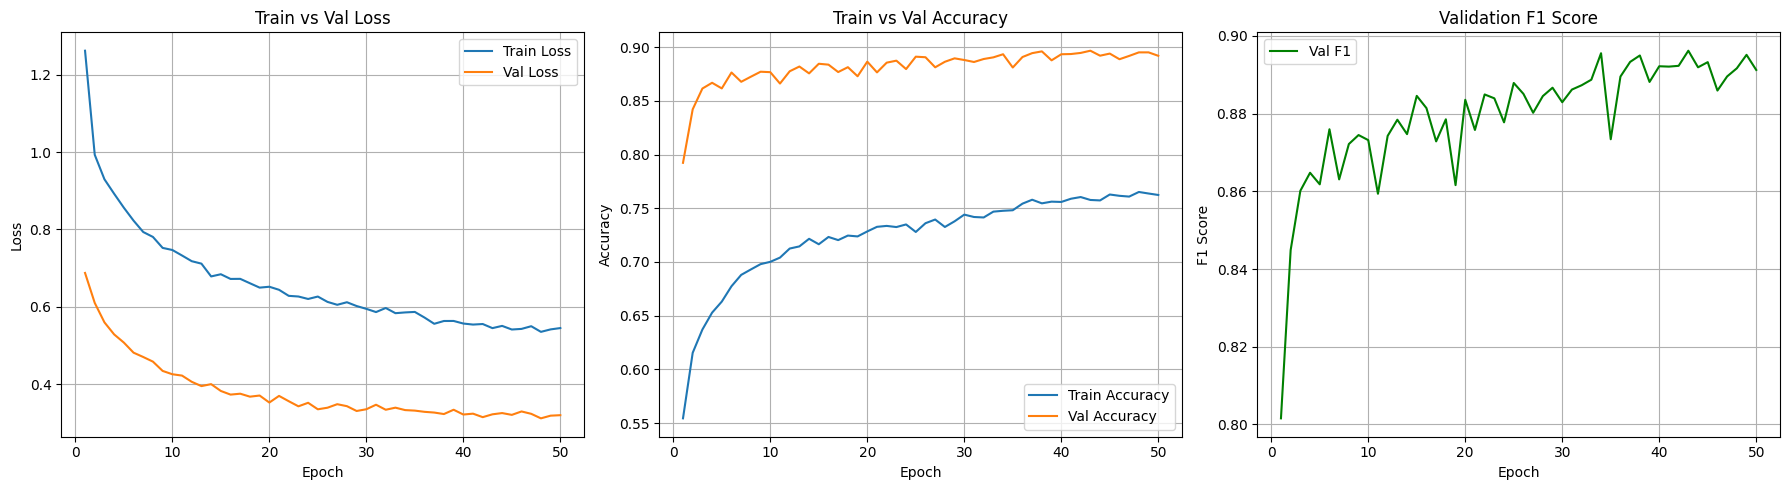


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:42<00:00, 135.76it/s]



====== Test Results ======
Overall Loss: 0.3225
Overall Accuracy: 0.8920
Cohen's Kappa: 0.8233
Per Class F1: [0.89302717 0.89154786 0.89102174]
Macro (Avg) F1: 0.8919


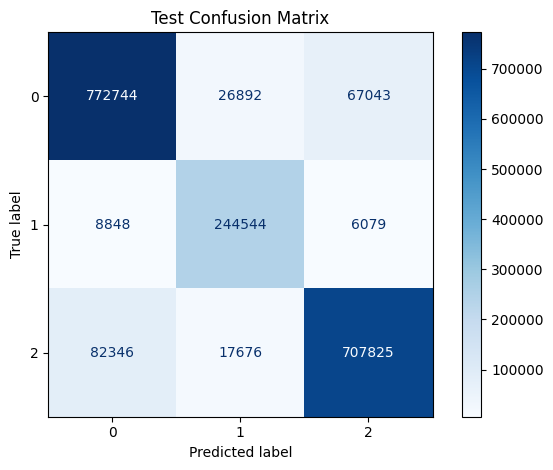

History Dumped in file /kaggle/working/true_BCNN_data_bald_history.json


====== Loading Data /kaggle/input/data-al/true_BCNN_data_bvsb.npz ======
Train Data:  (14000, 28, 6) (14000,)


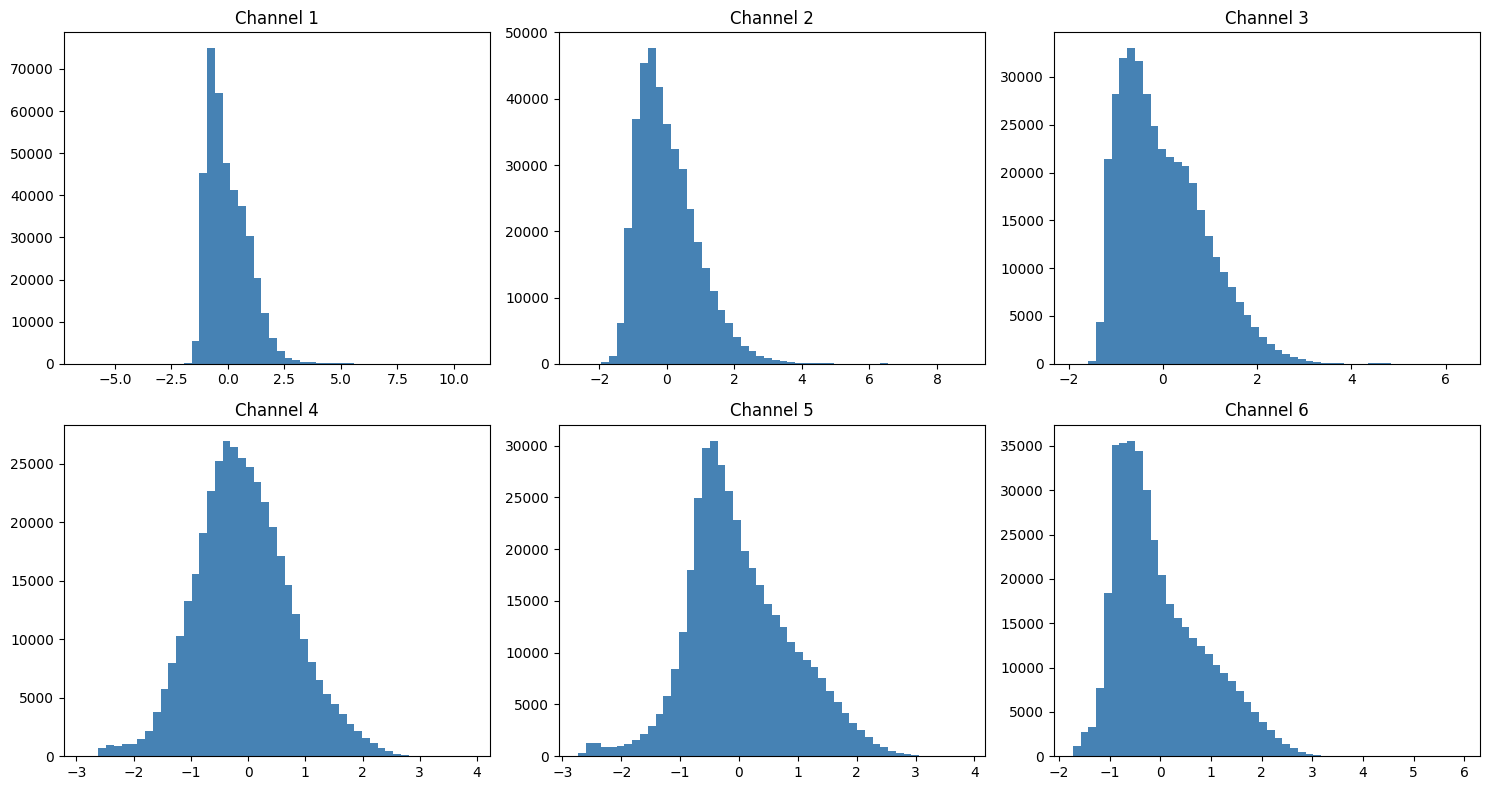

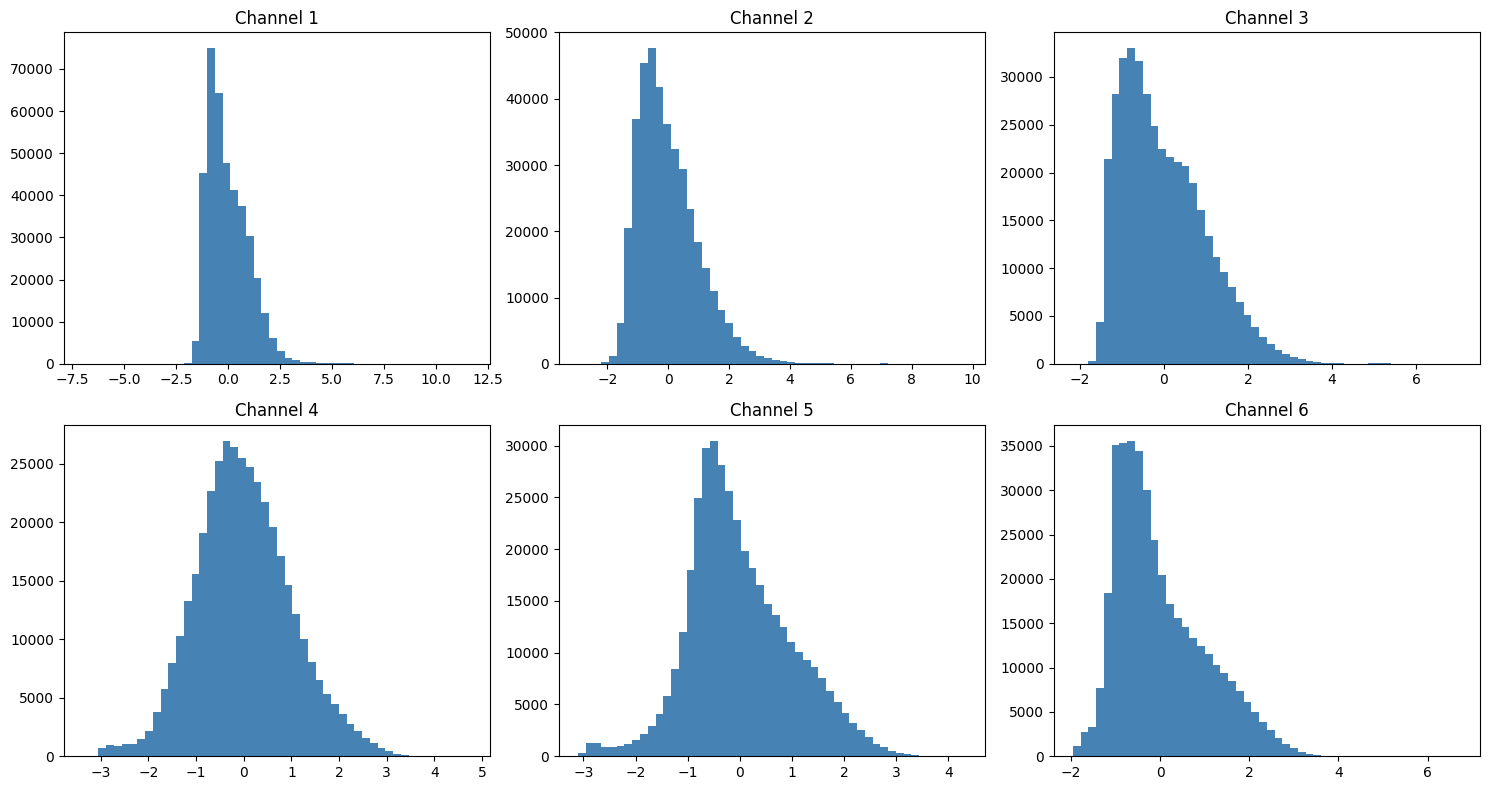



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6262      44.73%
1         1620      11.57%
2         6118      43.70%

Total samples: 14000


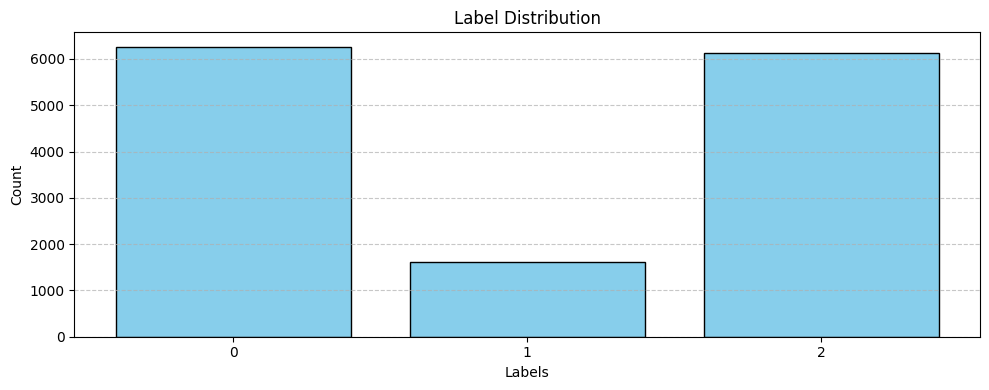


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


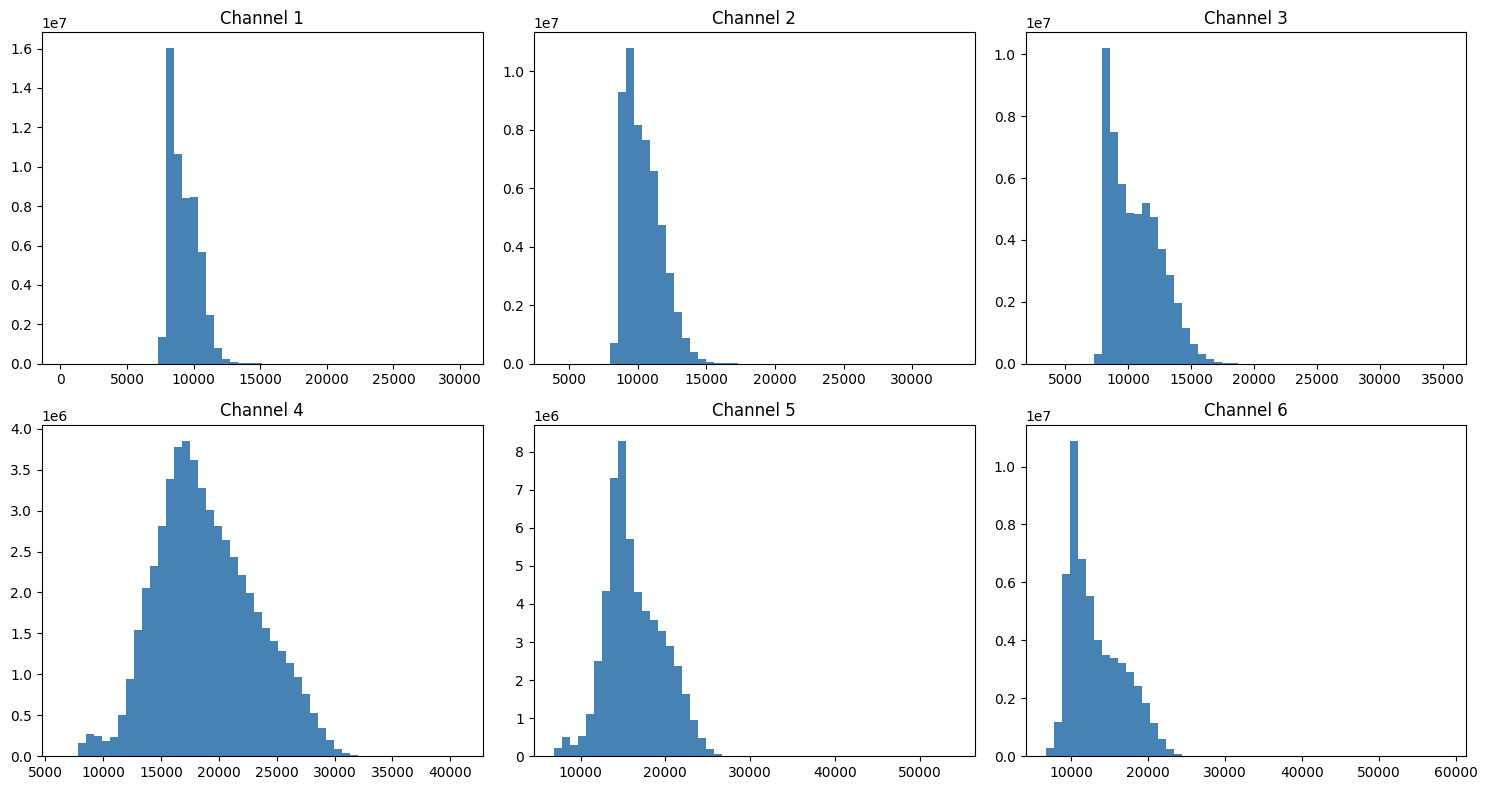

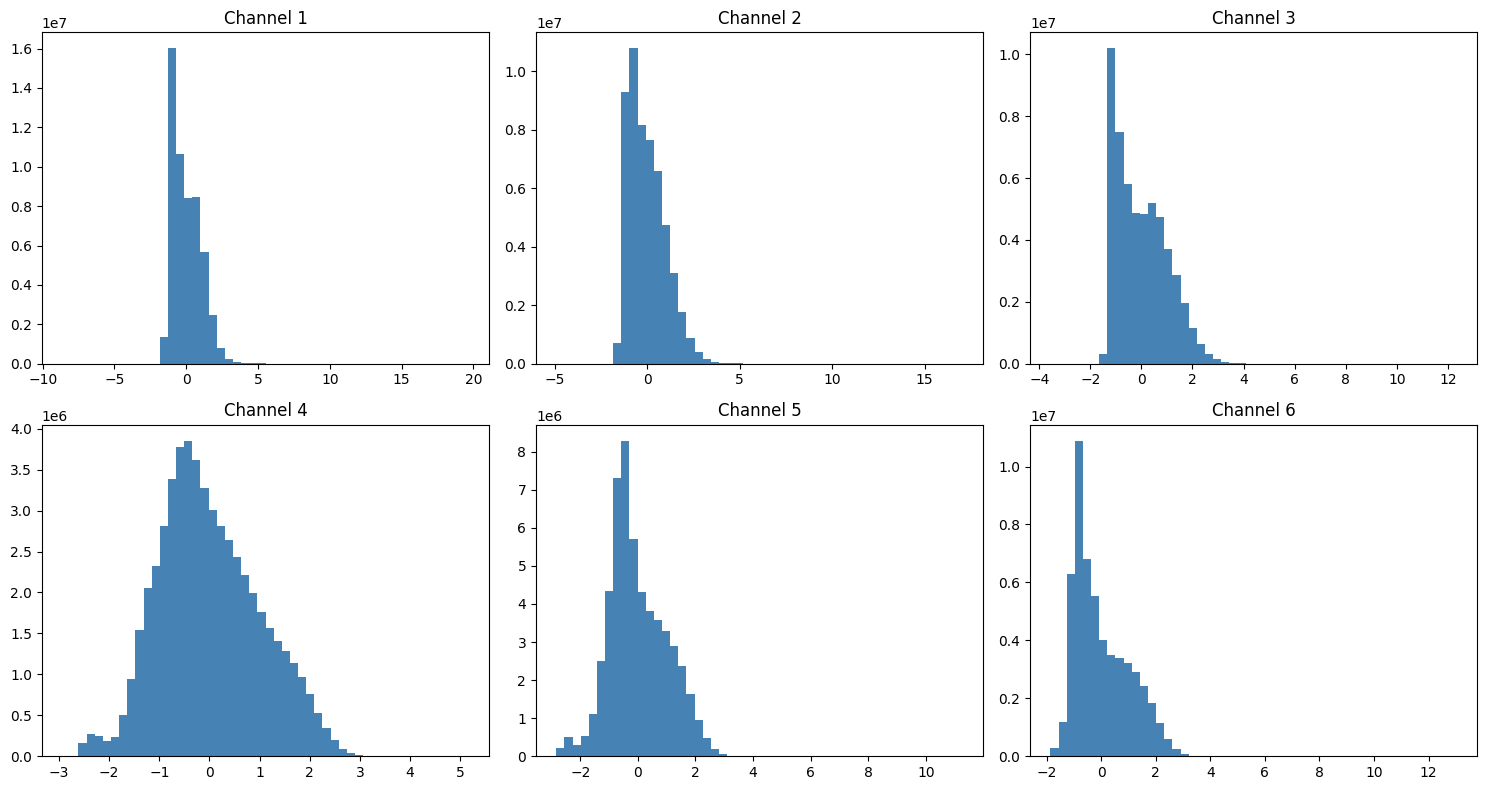



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


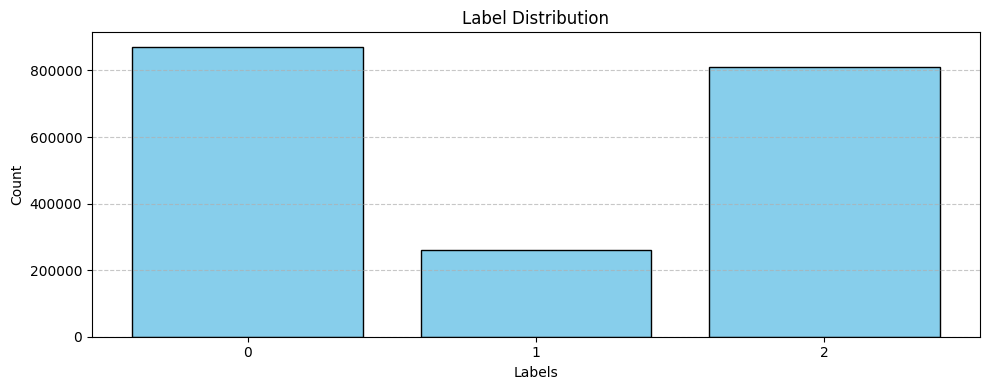

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.7452, 2.8807, 0.7628], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 1.0112 + 1e-07 * 2709709.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.71it/s]


Epoch [1/50] Train Loss: 1.4008, Train Acc: 0.5038 | Val Loss: 0.7117, Val Acc: 0.8101, F1: 0.8170, Kappa: 0.6904


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.78it/s]


Loss: 0.8124 + 1e-07 * 2535318.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.93it/s]


Epoch [2/50] Train Loss: 1.1465, Train Acc: 0.5379 | Val Loss: 0.6911, Val Acc: 0.8329, F1: 0.8346, Kappa: 0.7280


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.8251 + 1e-07 * 2363793.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.30it/s]


Epoch [3/50] Train Loss: 1.0856, Train Acc: 0.5471 | Val Loss: 0.6455, Val Acc: 0.8506, F1: 0.8508, Kappa: 0.7575


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.7371 + 1e-07 * 2204798.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.02it/s]


Epoch [4/50] Train Loss: 1.0524, Train Acc: 0.5541 | Val Loss: 0.6175, Val Acc: 0.8516, F1: 0.8472, Kappa: 0.7602


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.8918 + 1e-07 * 2057152.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.55it/s]


Epoch [5/50] Train Loss: 1.0187, Train Acc: 0.5643 | Val Loss: 0.5843, Val Acc: 0.8605, F1: 0.8576, Kappa: 0.7741


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.6854 + 1e-07 * 1926161.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.70it/s]


Epoch [6/50] Train Loss: 1.0007, Train Acc: 0.5606 | Val Loss: 0.5720, Val Acc: 0.8593, F1: 0.8551, Kappa: 0.7724


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.97it/s]


Loss: 0.7916 + 1e-07 * 1807284.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.65it/s]


Epoch [7/50] Train Loss: 0.9800, Train Acc: 0.5719 | Val Loss: 0.5577, Val Acc: 0.8647, F1: 0.8635, Kappa: 0.7802


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.8317 + 1e-07 * 1703243.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.61it/s]


Epoch [8/50] Train Loss: 0.9577, Train Acc: 0.5696 | Val Loss: 0.5320, Val Acc: 0.8651, F1: 0.8610, Kappa: 0.7815


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.6495 + 1e-07 * 1607961.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.95it/s]


Epoch [9/50] Train Loss: 0.9452, Train Acc: 0.5722 | Val Loss: 0.5203, Val Acc: 0.8686, F1: 0.8643, Kappa: 0.7866


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.9313 + 1e-07 * 1524959.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.99it/s]


Epoch [10/50] Train Loss: 0.9239, Train Acc: 0.5844 | Val Loss: 0.5028, Val Acc: 0.8659, F1: 0.8657, Kappa: 0.7820


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.4841 + 1e-07 * 1448880.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.83it/s]


Epoch [11/50] Train Loss: 0.9208, Train Acc: 0.5763 | Val Loss: 0.4943, Val Acc: 0.8734, F1: 0.8677, Kappa: 0.7949


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.8772 + 1e-07 * 1382235.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.29it/s]


Epoch [12/50] Train Loss: 0.9095, Train Acc: 0.5788 | Val Loss: 0.4600, Val Acc: 0.8694, F1: 0.8662, Kappa: 0.7883


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.7357 + 1e-07 * 1321113.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.04it/s]


Epoch [13/50] Train Loss: 0.8959, Train Acc: 0.5866 | Val Loss: 0.4542, Val Acc: 0.8759, F1: 0.8702, Kappa: 0.7988


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.6812 + 1e-07 * 1266254.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.51it/s]


Epoch [14/50] Train Loss: 0.8806, Train Acc: 0.5895 | Val Loss: 0.4491, Val Acc: 0.8781, F1: 0.8732, Kappa: 0.8018


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.7994 + 1e-07 * 1216818.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.23it/s]


Epoch [15/50] Train Loss: 0.8758, Train Acc: 0.5890 | Val Loss: 0.4430, Val Acc: 0.8762, F1: 0.8696, Kappa: 0.7993


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.61it/s]


Loss: 0.7799 + 1e-07 * 1171711.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.25it/s]


Epoch [16/50] Train Loss: 0.8678, Train Acc: 0.5913 | Val Loss: 0.4222, Val Acc: 0.8827, F1: 0.8758, Kappa: 0.8097


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.84it/s]


Loss: 0.6525 + 1e-07 * 1133085.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.71it/s]


Epoch [17/50] Train Loss: 0.8643, Train Acc: 0.5931 | Val Loss: 0.4404, Val Acc: 0.8855, F1: 0.8817, Kappa: 0.8135


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.5916 + 1e-07 * 1095658.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.83it/s]


Epoch [18/50] Train Loss: 0.8514, Train Acc: 0.5955 | Val Loss: 0.4314, Val Acc: 0.8821, F1: 0.8748, Kappa: 0.8088


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.60it/s]


Loss: 0.6602 + 1e-07 * 1061344.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.58it/s]


Epoch [19/50] Train Loss: 0.8486, Train Acc: 0.5916 | Val Loss: 0.4181, Val Acc: 0.8853, F1: 0.8806, Kappa: 0.8133


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.7112 + 1e-07 * 1031825.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.92it/s]


Epoch [20/50] Train Loss: 0.8474, Train Acc: 0.5942 | Val Loss: 0.4391, Val Acc: 0.8867, F1: 0.8813, Kappa: 0.8161


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.8798 + 1e-07 * 1004853.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.15it/s]


Epoch [21/50] Train Loss: 0.8362, Train Acc: 0.6001 | Val Loss: 0.4237, Val Acc: 0.8820, F1: 0.8799, Kappa: 0.8078


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 1.1563 + 1e-07 * 978990.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.58it/s]


Epoch [22/50] Train Loss: 0.8362, Train Acc: 0.5946 | Val Loss: 0.4132, Val Acc: 0.8784, F1: 0.8719, Kappa: 0.8028


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 43.09it/s]


Loss: 0.6851 + 1e-07 * 955452.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.04it/s]


Epoch [23/50] Train Loss: 0.8177, Train Acc: 0.6056 | Val Loss: 0.4133, Val Acc: 0.8875, F1: 0.8879, Kappa: 0.8158


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.8794 + 1e-07 * 935141.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.12it/s]


Epoch [24/50] Train Loss: 0.8193, Train Acc: 0.6054 | Val Loss: 0.3999, Val Acc: 0.8833, F1: 0.8824, Kappa: 0.8096


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.87it/s]


Loss: 0.6750 + 1e-07 * 915231.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.62it/s]


Epoch [25/50] Train Loss: 0.8148, Train Acc: 0.6091 | Val Loss: 0.3881, Val Acc: 0.8845, F1: 0.8814, Kappa: 0.8120


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.83it/s]


Loss: 0.5888 + 1e-07 * 897608.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.65it/s]


Epoch [26/50] Train Loss: 0.8131, Train Acc: 0.6049 | Val Loss: 0.3843, Val Acc: 0.8834, F1: 0.8788, Kappa: 0.8106


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.65it/s]


Loss: 0.6498 + 1e-07 * 880927.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.90it/s]


Epoch [27/50] Train Loss: 0.8050, Train Acc: 0.6069 | Val Loss: 0.3834, Val Acc: 0.8848, F1: 0.8822, Kappa: 0.8122


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 42.94it/s]


Loss: 0.9327 + 1e-07 * 864919.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.97it/s]


Epoch [28/50] Train Loss: 0.8072, Train Acc: 0.6118 | Val Loss: 0.3836, Val Acc: 0.8858, F1: 0.8829, Kappa: 0.8141


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.7395 + 1e-07 * 851040.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.21it/s]


Epoch [29/50] Train Loss: 0.8077, Train Acc: 0.6042 | Val Loss: 0.3980, Val Acc: 0.8888, F1: 0.8870, Kappa: 0.8187


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.53it/s]


Loss: 0.7743 + 1e-07 * 837641.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.37it/s]


Epoch [30/50] Train Loss: 0.7977, Train Acc: 0.6096 | Val Loss: 0.3926, Val Acc: 0.8905, F1: 0.8892, Kappa: 0.8212


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.39it/s]


Loss: 0.6069 + 1e-07 * 826060.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.15it/s]


Epoch [31/50] Train Loss: 0.7981, Train Acc: 0.6155 | Val Loss: 0.3770, Val Acc: 0.8878, F1: 0.8838, Kappa: 0.8174


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.41it/s]


Loss: 0.8614 + 1e-07 * 815540.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.49it/s]


Epoch [32/50] Train Loss: 0.7887, Train Acc: 0.6123 | Val Loss: 0.3766, Val Acc: 0.8873, F1: 0.8850, Kappa: 0.8163


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.7660 + 1e-07 * 804854.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.74it/s]


Epoch [33/50] Train Loss: 0.7870, Train Acc: 0.6115 | Val Loss: 0.3806, Val Acc: 0.8839, F1: 0.8803, Kappa: 0.8109


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.8223 + 1e-07 * 794348.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.89it/s]


Epoch [34/50] Train Loss: 0.7905, Train Acc: 0.6128 | Val Loss: 0.3786, Val Acc: 0.8858, F1: 0.8836, Kappa: 0.8135


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.44it/s]


Loss: 0.6124 + 1e-07 * 786519.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.69it/s]


Epoch [35/50] Train Loss: 0.7879, Train Acc: 0.6136 | Val Loss: 0.3784, Val Acc: 0.8853, F1: 0.8825, Kappa: 0.8129


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.39it/s]


Loss: 0.8423 + 1e-07 * 777388.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.18it/s]


Epoch [36/50] Train Loss: 0.7818, Train Acc: 0.6200 | Val Loss: 0.3594, Val Acc: 0.8863, F1: 0.8854, Kappa: 0.8142


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.01it/s]


Loss: 0.5941 + 1e-07 * 770807.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.78it/s]


Epoch [37/50] Train Loss: 0.7847, Train Acc: 0.6141 | Val Loss: 0.3699, Val Acc: 0.8788, F1: 0.8769, Kappa: 0.8029


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.75it/s]


Loss: 0.8199 + 1e-07 * 762437.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.35it/s]


Epoch [38/50] Train Loss: 0.7801, Train Acc: 0.6134 | Val Loss: 0.3701, Val Acc: 0.8840, F1: 0.8789, Kappa: 0.8117


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.5800 + 1e-07 * 755565.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.59it/s]


Epoch [39/50] Train Loss: 0.7819, Train Acc: 0.6204 | Val Loss: 0.3569, Val Acc: 0.8889, F1: 0.8871, Kappa: 0.8186


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.8042 + 1e-07 * 749332.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.67it/s]


Epoch [40/50] Train Loss: 0.7735, Train Acc: 0.6242 | Val Loss: 0.3681, Val Acc: 0.8866, F1: 0.8847, Kappa: 0.8151


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.7394 + 1e-07 * 743064.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.30it/s]


Epoch [41/50] Train Loss: 0.7702, Train Acc: 0.6187 | Val Loss: 0.3700, Val Acc: 0.8885, F1: 0.8839, Kappa: 0.8185


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.7925 + 1e-07 * 737042.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.69it/s]


Epoch [42/50] Train Loss: 0.7766, Train Acc: 0.6171 | Val Loss: 0.3775, Val Acc: 0.8892, F1: 0.8871, Kappa: 0.8190


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.80it/s]


Loss: 0.6111 + 1e-07 * 732800.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.99it/s]


Epoch [43/50] Train Loss: 0.7680, Train Acc: 0.6219 | Val Loss: 0.3625, Val Acc: 0.8854, F1: 0.8835, Kappa: 0.8132


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.98it/s]


Loss: 0.7518 + 1e-07 * 728304.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 139.06it/s]


Epoch [44/50] Train Loss: 0.7724, Train Acc: 0.6236 | Val Loss: 0.3781, Val Acc: 0.8840, F1: 0.8854, Kappa: 0.8101


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.47it/s]


Loss: 0.5438 + 1e-07 * 724580.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.72it/s]


Epoch [45/50] Train Loss: 0.7657, Train Acc: 0.6228 | Val Loss: 0.3673, Val Acc: 0.8886, F1: 0.8859, Kappa: 0.8182


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 42.58it/s]


Loss: 0.7237 + 1e-07 * 718416.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.08it/s]


Epoch [46/50] Train Loss: 0.7623, Train Acc: 0.6276 | Val Loss: 0.3594, Val Acc: 0.8914, F1: 0.8888, Kappa: 0.8227


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.9400 + 1e-07 * 713357.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.10it/s]


Epoch [47/50] Train Loss: 0.7508, Train Acc: 0.6331 | Val Loss: 0.3455, Val Acc: 0.8902, F1: 0.8893, Kappa: 0.8206


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.5483 + 1e-07 * 708717.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.42it/s]


Epoch [48/50] Train Loss: 0.7547, Train Acc: 0.6290 | Val Loss: 0.3517, Val Acc: 0.8881, F1: 0.8853, Kappa: 0.8174


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.73it/s]


Loss: 0.5689 + 1e-07 * 704425.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.91it/s]


Epoch [49/50] Train Loss: 0.7389, Train Acc: 0.6329 | Val Loss: 0.3556, Val Acc: 0.8913, F1: 0.8886, Kappa: 0.8226


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.7832 + 1e-07 * 700859.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.45it/s]


Epoch [50/50] Train Loss: 0.7505, Train Acc: 0.6311 | Val Loss: 0.3499, Val Acc: 0.8912, F1: 0.8885, Kappa: 0.8223


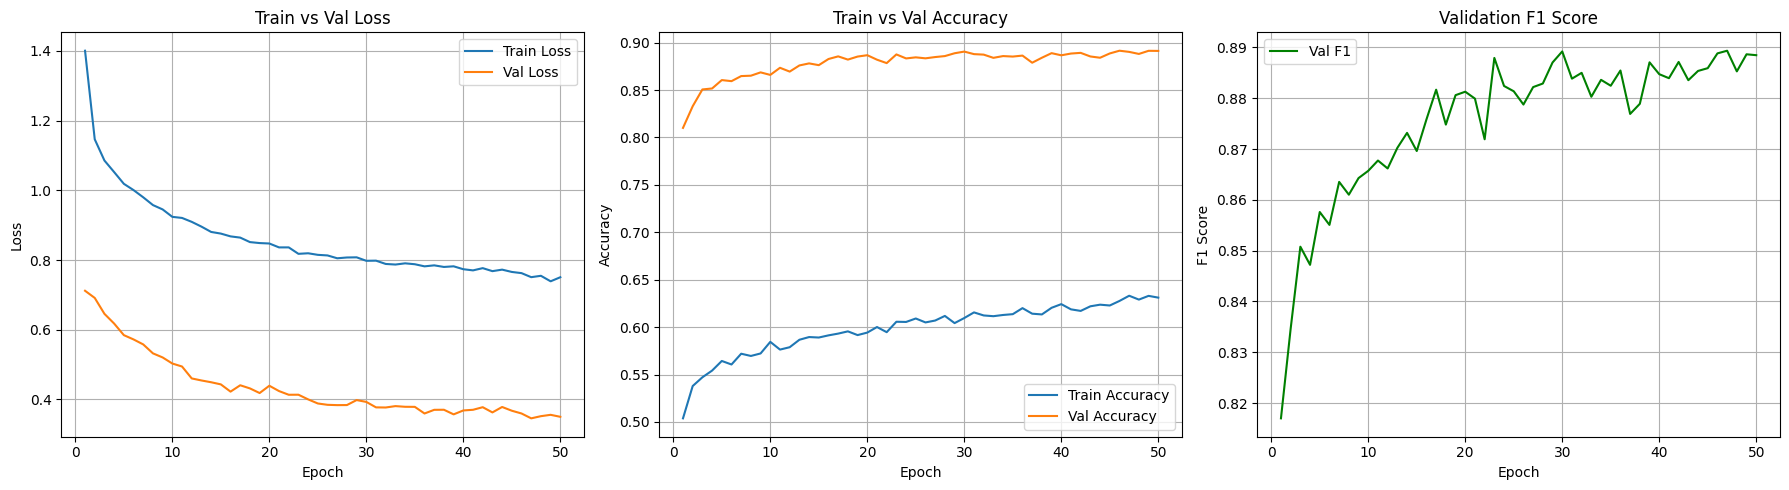


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:43<00:00, 135.28it/s]



====== Test Results ======
Overall Loss: 0.3473
Overall Accuracy: 0.8922
Cohen's Kappa: 0.8239
Per Class F1: [0.89759431 0.88225973 0.88981917]
Macro (Avg) F1: 0.8899


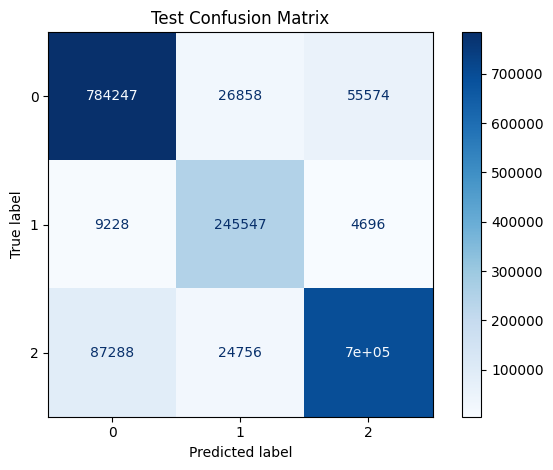

History Dumped in file /kaggle/working/true_BCNN_data_bvsb_history.json


====== Loading Data /kaggle/input/data-al/true_BCNN_data_predictive_entropy.npz ======
Train Data:  (14000, 28, 6) (14000,)


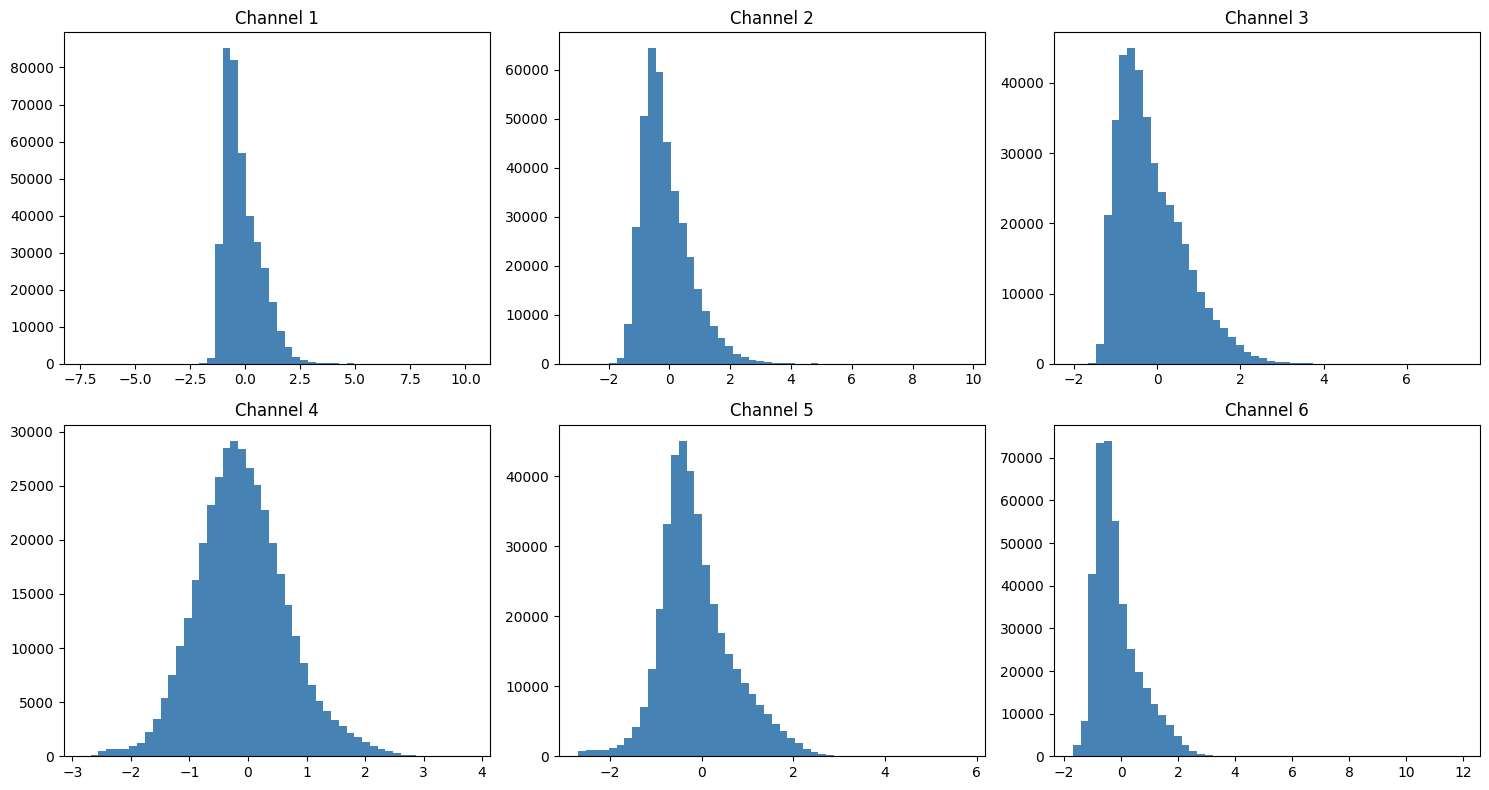

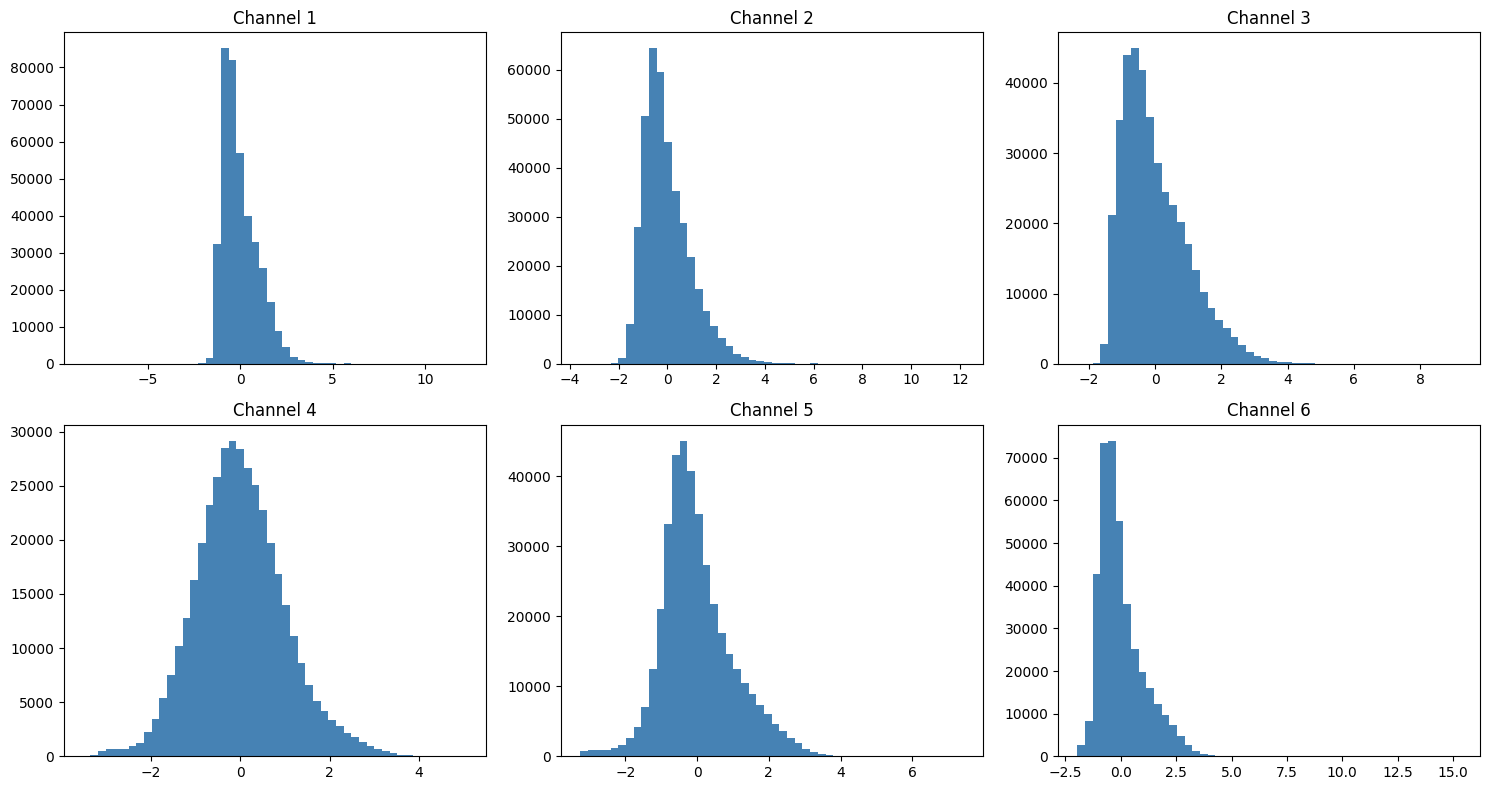



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         5702      40.73%
1         2487      17.76%
2         5811      41.51%

Total samples: 14000


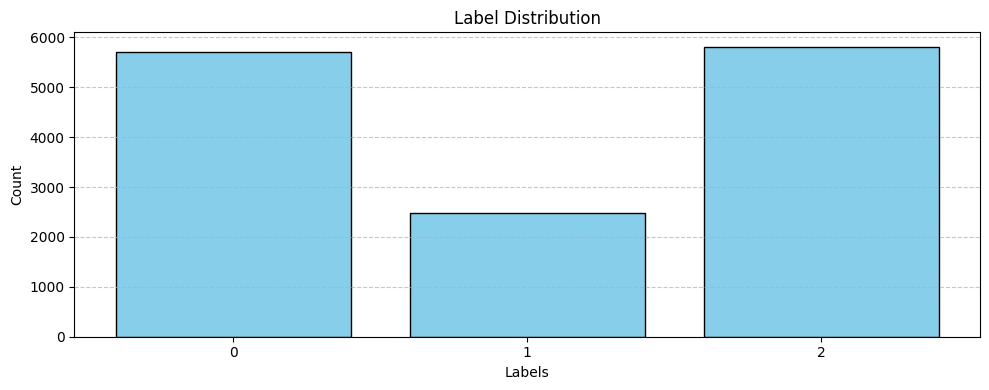


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


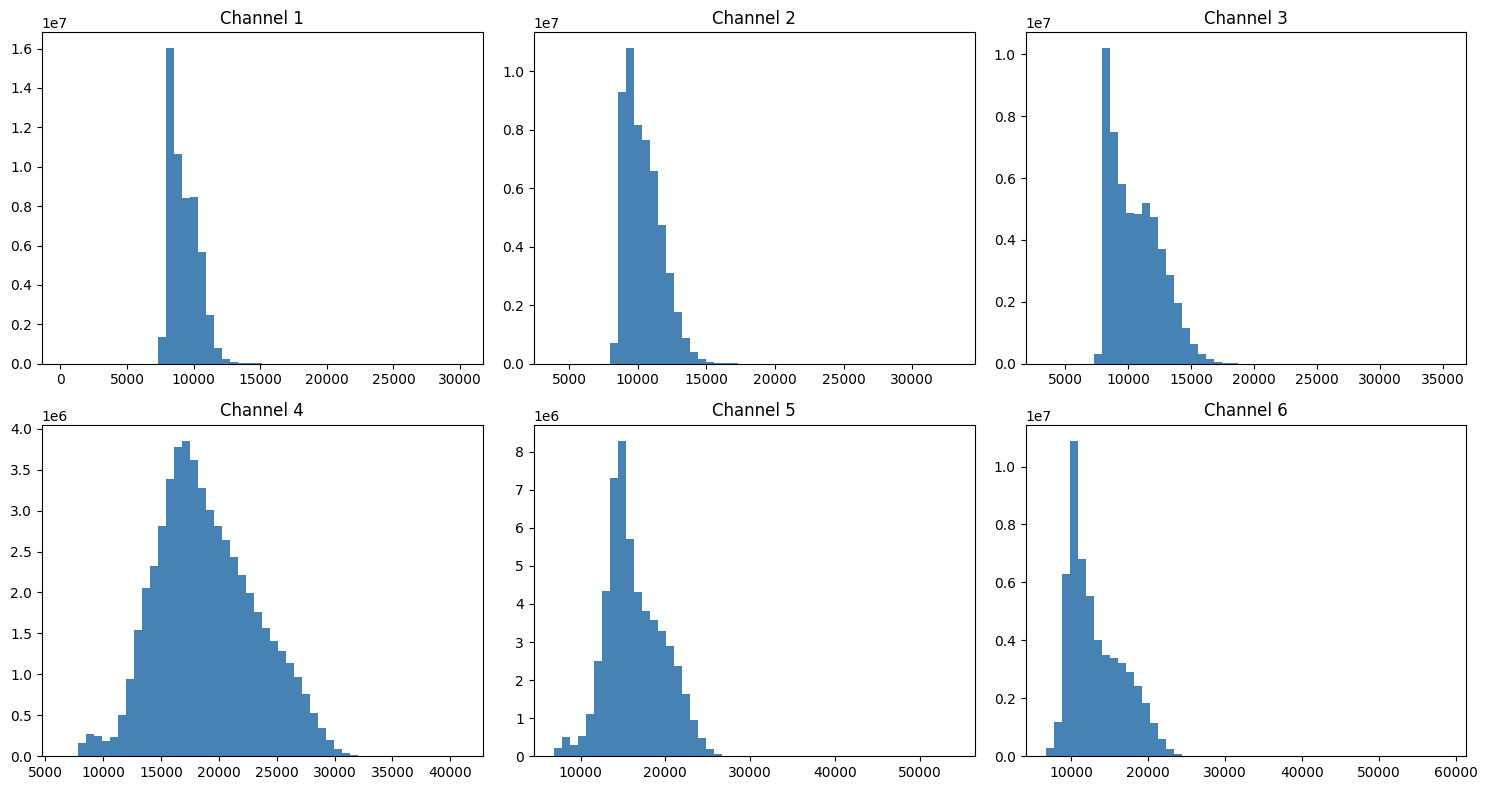

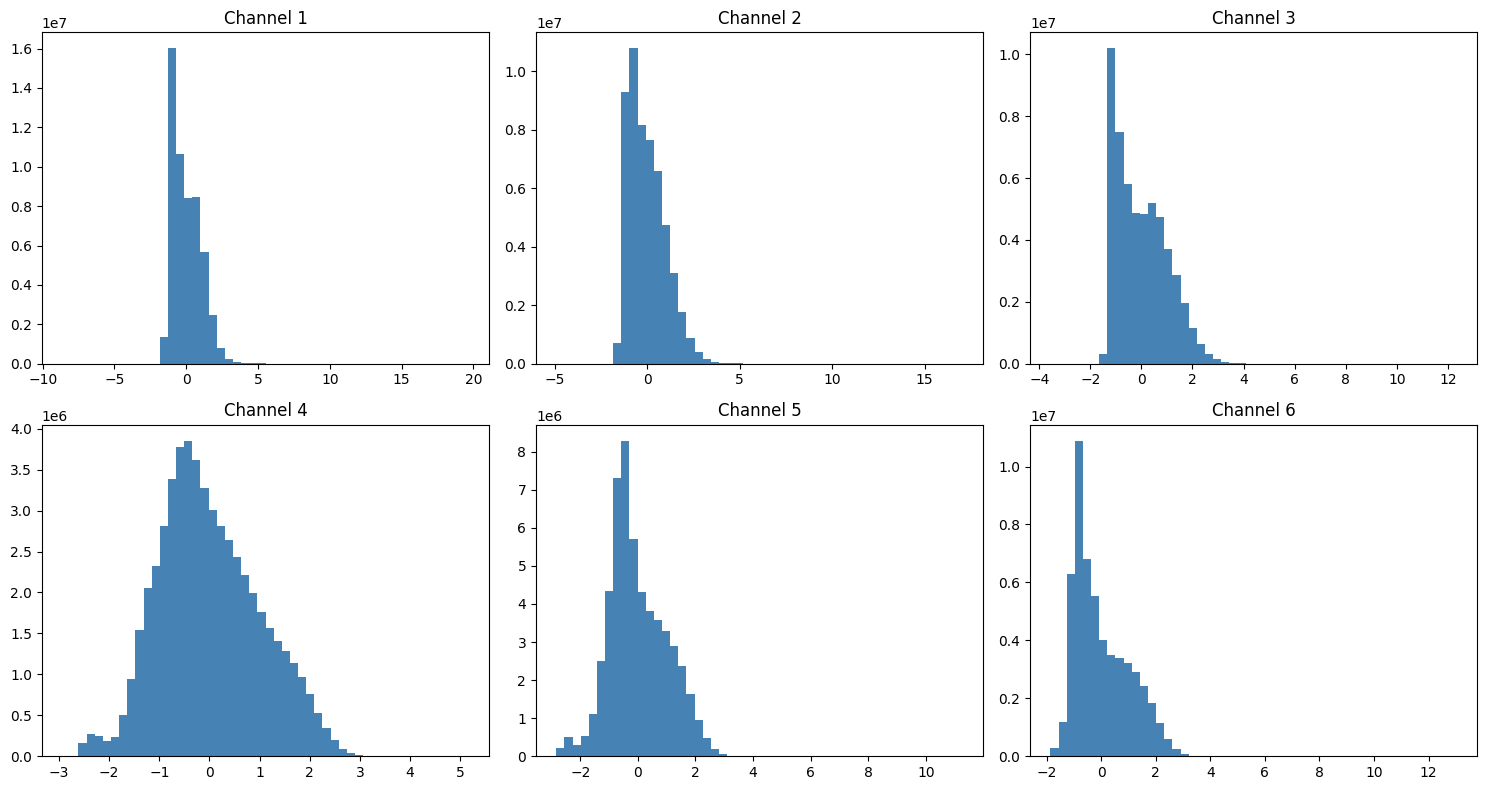



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


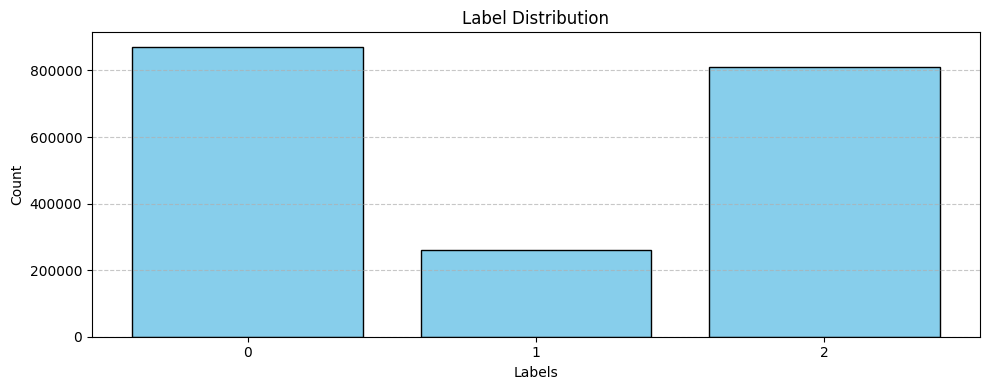

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.8184, 1.8764, 0.8031], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.41it/s]


Loss: 0.9540 + 1e-07 * 2698518.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.41it/s]


Epoch [1/50] Train Loss: 1.4853, Train Acc: 0.4769 | Val Loss: 0.7838, Val Acc: 0.7888, F1: 0.7931, Kappa: 0.6584


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.48it/s]


Loss: 0.9038 + 1e-07 * 2514332.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.12it/s]


Epoch [2/50] Train Loss: 1.2383, Train Acc: 0.5062 | Val Loss: 0.7489, Val Acc: 0.8209, F1: 0.8260, Kappa: 0.7091


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.17it/s]


Loss: 1.0052 + 1e-07 * 2332696.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.17it/s]


Epoch [3/50] Train Loss: 1.1882, Train Acc: 0.5241 | Val Loss: 0.7179, Val Acc: 0.8314, F1: 0.8313, Kappa: 0.7267


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.47it/s]


Loss: 0.9407 + 1e-07 * 2163322.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.03it/s]


Epoch [4/50] Train Loss: 1.1434, Train Acc: 0.5345 | Val Loss: 0.6799, Val Acc: 0.8365, F1: 0.8403, Kappa: 0.7341


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.48it/s]


Loss: 1.0205 + 1e-07 * 2011885.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.37it/s]


Epoch [5/50] Train Loss: 1.1228, Train Acc: 0.5374 | Val Loss: 0.6361, Val Acc: 0.8457, F1: 0.8487, Kappa: 0.7490


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.20it/s]


Loss: 1.0725 + 1e-07 * 1878369.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 132.96it/s]


Epoch [6/50] Train Loss: 1.1020, Train Acc: 0.5406 | Val Loss: 0.6195, Val Acc: 0.8564, F1: 0.8596, Kappa: 0.7654


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.95it/s]


Loss: 0.8046 + 1e-07 * 1758259.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.05it/s]


Epoch [7/50] Train Loss: 1.0740, Train Acc: 0.5485 | Val Loss: 0.6038, Val Acc: 0.8451, F1: 0.8468, Kappa: 0.7488


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.55it/s]


Loss: 0.7628 + 1e-07 * 1649587.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.78it/s]


Epoch [8/50] Train Loss: 1.0619, Train Acc: 0.5454 | Val Loss: 0.5812, Val Acc: 0.8492, F1: 0.8514, Kappa: 0.7550


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.57it/s]


Loss: 0.8789 + 1e-07 * 1552896.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.26it/s]


Epoch [9/50] Train Loss: 1.0398, Train Acc: 0.5543 | Val Loss: 0.5548, Val Acc: 0.8583, F1: 0.8604, Kappa: 0.7694


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.8866 + 1e-07 * 1470060.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.39it/s]


Epoch [10/50] Train Loss: 1.0240, Train Acc: 0.5521 | Val Loss: 0.5342, Val Acc: 0.8590, F1: 0.8598, Kappa: 0.7710


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.92it/s]


Loss: 0.7417 + 1e-07 * 1395391.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.87it/s]


Epoch [11/50] Train Loss: 1.0192, Train Acc: 0.5487 | Val Loss: 0.5283, Val Acc: 0.8629, F1: 0.8642, Kappa: 0.7768


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.9020 + 1e-07 * 1327356.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.54it/s]


Epoch [12/50] Train Loss: 1.0033, Train Acc: 0.5565 | Val Loss: 0.4987, Val Acc: 0.8598, F1: 0.8597, Kappa: 0.7724


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.55it/s]


Loss: 0.9802 + 1e-07 * 1267985.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.79it/s]


Epoch [13/50] Train Loss: 0.9917, Train Acc: 0.5574 | Val Loss: 0.5081, Val Acc: 0.8367, F1: 0.8440, Kappa: 0.7343


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.55it/s]


Loss: 0.7780 + 1e-07 * 1214929.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.14it/s]


Epoch [14/50] Train Loss: 0.9808, Train Acc: 0.5666 | Val Loss: 0.5035, Val Acc: 0.8650, F1: 0.8645, Kappa: 0.7806


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.7647 + 1e-07 * 1167888.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.51it/s]


Epoch [15/50] Train Loss: 0.9702, Train Acc: 0.5685 | Val Loss: 0.4810, Val Acc: 0.8675, F1: 0.8676, Kappa: 0.7843


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.50it/s]


Loss: 0.8810 + 1e-07 * 1122884.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.01it/s]


Epoch [16/50] Train Loss: 0.9630, Train Acc: 0.5689 | Val Loss: 0.4742, Val Acc: 0.8545, F1: 0.8580, Kappa: 0.7633


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.9877 + 1e-07 * 1083887.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.66it/s]


Epoch [17/50] Train Loss: 0.9680, Train Acc: 0.5629 | Val Loss: 0.4703, Val Acc: 0.8644, F1: 0.8657, Kappa: 0.7795


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.89it/s]


Loss: 0.8314 + 1e-07 * 1048065.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.10it/s]


Epoch [18/50] Train Loss: 0.9583, Train Acc: 0.5691 | Val Loss: 0.4750, Val Acc: 0.8660, F1: 0.8658, Kappa: 0.7821


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.62it/s]


Loss: 0.9016 + 1e-07 * 1015353.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.85it/s]


Epoch [19/50] Train Loss: 0.9475, Train Acc: 0.5736 | Val Loss: 0.5112, Val Acc: 0.8414, F1: 0.8457, Kappa: 0.7413


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.7571 + 1e-07 * 986441.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.90it/s]


Epoch [20/50] Train Loss: 0.9507, Train Acc: 0.5713 | Val Loss: 0.4683, Val Acc: 0.8732, F1: 0.8738, Kappa: 0.7931


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.93it/s]


Loss: 0.7757 + 1e-07 * 958576.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.30it/s]


Epoch [21/50] Train Loss: 0.9355, Train Acc: 0.5786 | Val Loss: 0.4649, Val Acc: 0.8646, F1: 0.8653, Kappa: 0.7796


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.69it/s]


Loss: 0.8330 + 1e-07 * 933763.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.57it/s]


Epoch [22/50] Train Loss: 0.9333, Train Acc: 0.5738 | Val Loss: 0.4801, Val Acc: 0.8586, F1: 0.8605, Kappa: 0.7696


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.8156 + 1e-07 * 911192.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.89it/s]


Epoch [23/50] Train Loss: 0.9340, Train Acc: 0.5702 | Val Loss: 0.4531, Val Acc: 0.8663, F1: 0.8660, Kappa: 0.7822


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.52it/s]


Loss: 0.8280 + 1e-07 * 889803.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.49it/s]


Epoch [24/50] Train Loss: 0.9229, Train Acc: 0.5771 | Val Loss: 0.4319, Val Acc: 0.8760, F1: 0.8775, Kappa: 0.7973


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.62it/s]


Loss: 1.0128 + 1e-07 * 870854.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.65it/s]


Epoch [25/50] Train Loss: 0.9230, Train Acc: 0.5728 | Val Loss: 0.4734, Val Acc: 0.8529, F1: 0.8579, Kappa: 0.7589


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.7647 + 1e-07 * 852760.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.31it/s]


Epoch [26/50] Train Loss: 0.9219, Train Acc: 0.5797 | Val Loss: 0.4264, Val Acc: 0.8760, F1: 0.8768, Kappa: 0.7974


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.34it/s]


Loss: 0.8707 + 1e-07 * 835487.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.60it/s]


Epoch [27/50] Train Loss: 0.9112, Train Acc: 0.5785 | Val Loss: 0.4170, Val Acc: 0.8716, F1: 0.8730, Kappa: 0.7904


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 42.45it/s]


Loss: 0.8603 + 1e-07 * 820401.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 132.89it/s]


Epoch [28/50] Train Loss: 0.9137, Train Acc: 0.5831 | Val Loss: 0.4090, Val Acc: 0.8779, F1: 0.8765, Kappa: 0.8010


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.58it/s]


Loss: 0.8862 + 1e-07 * 806299.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.80it/s]


Epoch [29/50] Train Loss: 0.9075, Train Acc: 0.5883 | Val Loss: 0.4203, Val Acc: 0.8764, F1: 0.8767, Kappa: 0.7983


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.69it/s]


Loss: 0.7032 + 1e-07 * 793079.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.32it/s]


Epoch [30/50] Train Loss: 0.8986, Train Acc: 0.5874 | Val Loss: 0.4140, Val Acc: 0.8764, F1: 0.8767, Kappa: 0.7985


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.7531 + 1e-07 * 781585.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.04it/s]


Epoch [31/50] Train Loss: 0.9023, Train Acc: 0.5784 | Val Loss: 0.4380, Val Acc: 0.8680, F1: 0.8686, Kappa: 0.7850


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.37it/s]


Loss: 0.9477 + 1e-07 * 770631.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.00it/s]


Epoch [32/50] Train Loss: 0.9027, Train Acc: 0.5811 | Val Loss: 0.4225, Val Acc: 0.8713, F1: 0.8713, Kappa: 0.7903


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.7689 + 1e-07 * 761160.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.98it/s]


Epoch [33/50] Train Loss: 0.8976, Train Acc: 0.5844 | Val Loss: 0.4094, Val Acc: 0.8726, F1: 0.8735, Kappa: 0.7926


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.57it/s]


Loss: 0.7187 + 1e-07 * 752882.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.22it/s]


Epoch [34/50] Train Loss: 0.8943, Train Acc: 0.5887 | Val Loss: 0.4146, Val Acc: 0.8768, F1: 0.8766, Kappa: 0.7992


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.33it/s]


Loss: 0.8130 + 1e-07 * 744634.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.82it/s]


Epoch [35/50] Train Loss: 0.8850, Train Acc: 0.5959 | Val Loss: 0.3912, Val Acc: 0.8730, F1: 0.8736, Kappa: 0.7932


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.7653 + 1e-07 * 737322.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.60it/s]


Epoch [36/50] Train Loss: 0.8821, Train Acc: 0.5902 | Val Loss: 0.3905, Val Acc: 0.8748, F1: 0.8748, Kappa: 0.7959


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.82it/s]


Loss: 0.7240 + 1e-07 * 730077.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.45it/s]


Epoch [37/50] Train Loss: 0.8779, Train Acc: 0.5933 | Val Loss: 0.3868, Val Acc: 0.8724, F1: 0.8719, Kappa: 0.7923


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.37it/s]


Loss: 0.8614 + 1e-07 * 723919.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.41it/s]


Epoch [38/50] Train Loss: 0.8786, Train Acc: 0.5919 | Val Loss: 0.3822, Val Acc: 0.8754, F1: 0.8761, Kappa: 0.7968


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.54it/s]


Loss: 0.7334 + 1e-07 * 718112.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.45it/s]


Epoch [39/50] Train Loss: 0.8678, Train Acc: 0.6004 | Val Loss: 0.3749, Val Acc: 0.8760, F1: 0.8749, Kappa: 0.7983


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.51it/s]


Loss: 0.7512 + 1e-07 * 712804.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.40it/s]


Epoch [40/50] Train Loss: 0.8691, Train Acc: 0.5996 | Val Loss: 0.3853, Val Acc: 0.8736, F1: 0.8733, Kappa: 0.7945


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.34it/s]


Loss: 0.6226 + 1e-07 * 707708.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.68it/s]


Epoch [41/50] Train Loss: 0.8748, Train Acc: 0.5919 | Val Loss: 0.3911, Val Acc: 0.8776, F1: 0.8765, Kappa: 0.8005


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 42.53it/s]


Loss: 0.8606 + 1e-07 * 702893.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.15it/s]


Epoch [42/50] Train Loss: 0.8693, Train Acc: 0.6048 | Val Loss: 0.4020, Val Acc: 0.8705, F1: 0.8698, Kappa: 0.7892


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.54it/s]


Loss: 0.7621 + 1e-07 * 698689.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.64it/s]


Epoch [43/50] Train Loss: 0.8777, Train Acc: 0.5916 | Val Loss: 0.3998, Val Acc: 0.8730, F1: 0.8722, Kappa: 0.7932


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.64it/s]


Loss: 0.6774 + 1e-07 * 694428.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 131.72it/s]


Epoch [44/50] Train Loss: 0.8703, Train Acc: 0.5966 | Val Loss: 0.4175, Val Acc: 0.8621, F1: 0.8645, Kappa: 0.7750


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.67it/s]


Loss: 0.6720 + 1e-07 * 690450.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.18it/s]


Epoch [45/50] Train Loss: 0.8671, Train Acc: 0.5959 | Val Loss: 0.4076, Val Acc: 0.8677, F1: 0.8680, Kappa: 0.7846


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 42.43it/s]


Loss: 0.7615 + 1e-07 * 687251.1875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.42it/s]


Epoch [46/50] Train Loss: 0.8597, Train Acc: 0.6028 | Val Loss: 0.3859, Val Acc: 0.8748, F1: 0.8759, Kappa: 0.7955


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.52it/s]


Loss: 0.7954 + 1e-07 * 684297.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.32it/s]


Epoch [47/50] Train Loss: 0.8598, Train Acc: 0.5984 | Val Loss: 0.3851, Val Acc: 0.8759, F1: 0.8758, Kappa: 0.7976


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.76it/s]


Loss: 0.9242 + 1e-07 * 681541.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.94it/s]


Epoch [48/50] Train Loss: 0.8648, Train Acc: 0.5982 | Val Loss: 0.3737, Val Acc: 0.8766, F1: 0.8773, Kappa: 0.7988


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.06it/s]


Loss: 0.7727 + 1e-07 * 678861.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.49it/s]


Epoch [49/50] Train Loss: 0.8543, Train Acc: 0.6069 | Val Loss: 0.3880, Val Acc: 0.8777, F1: 0.8796, Kappa: 0.7999


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.59it/s]


Loss: 0.7088 + 1e-07 * 676406.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.42it/s]


Epoch [50/50] Train Loss: 0.8593, Train Acc: 0.6000 | Val Loss: 0.3849, Val Acc: 0.8775, F1: 0.8777, Kappa: 0.8003


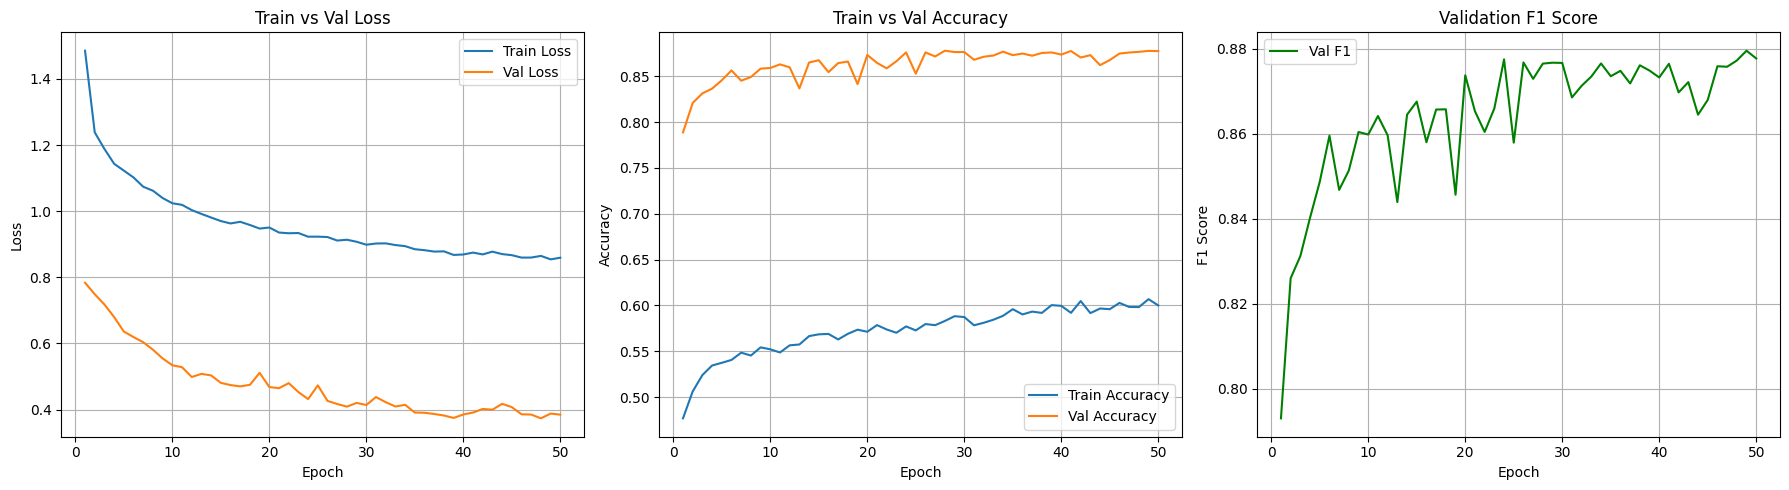


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:42<00:00, 135.81it/s]



====== Test Results ======
Overall Loss: 0.3881
Overall Accuracy: 0.8773
Cohen's Kappa: 0.7996
Per Class F1: [0.87659571 0.88311398 0.8760629 ]
Macro (Avg) F1: 0.8786


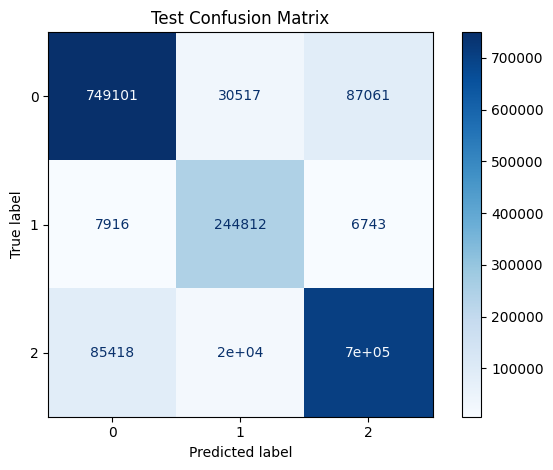

History Dumped in file /kaggle/working/true_BCNN_data_predictive_entropy_history.json


====== Loading Data /kaggle/input/data-al/true_BCNN_data_variation_ratio.npz ======
Train Data:  (14000, 28, 6) (14000,)


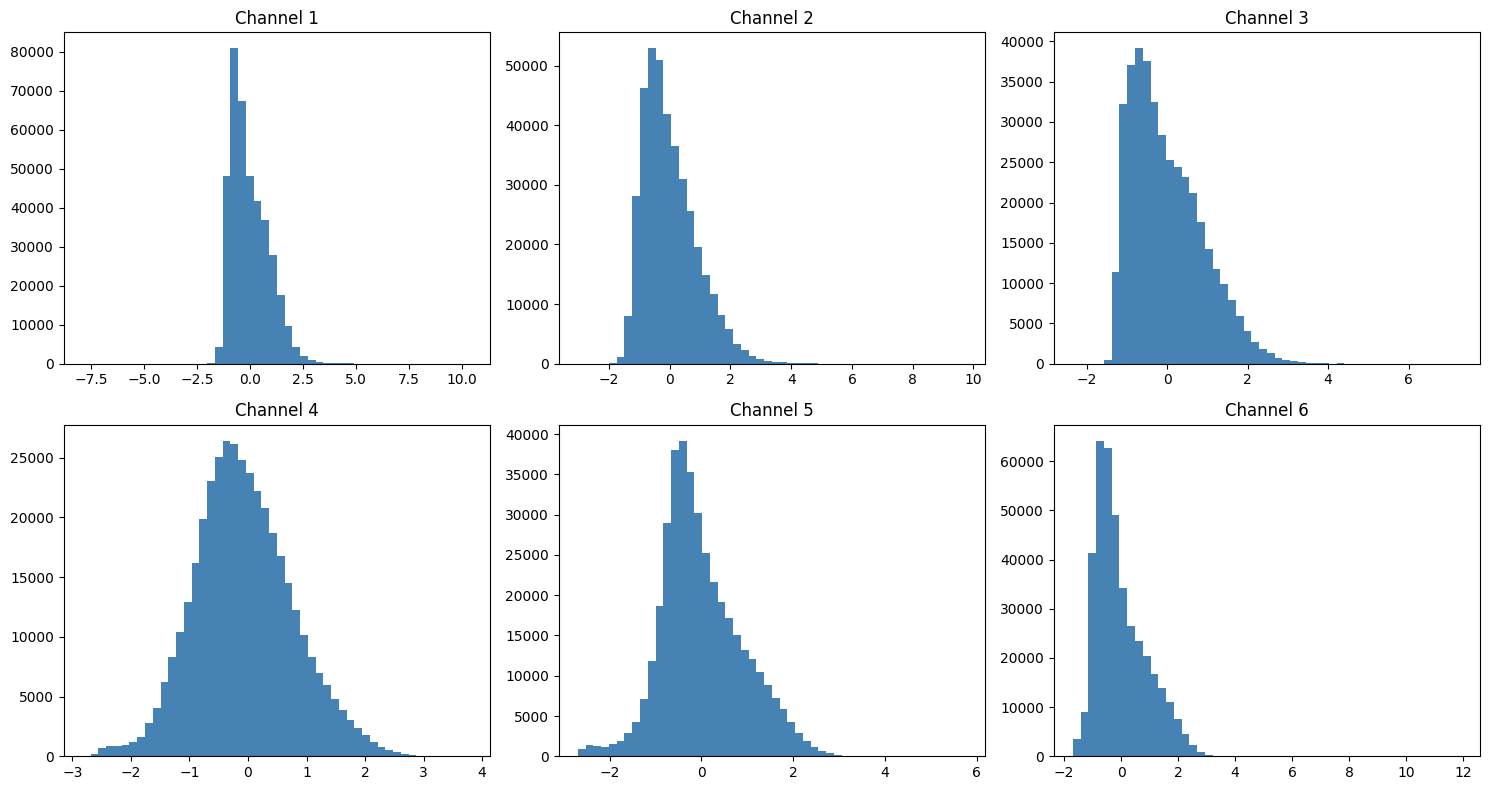

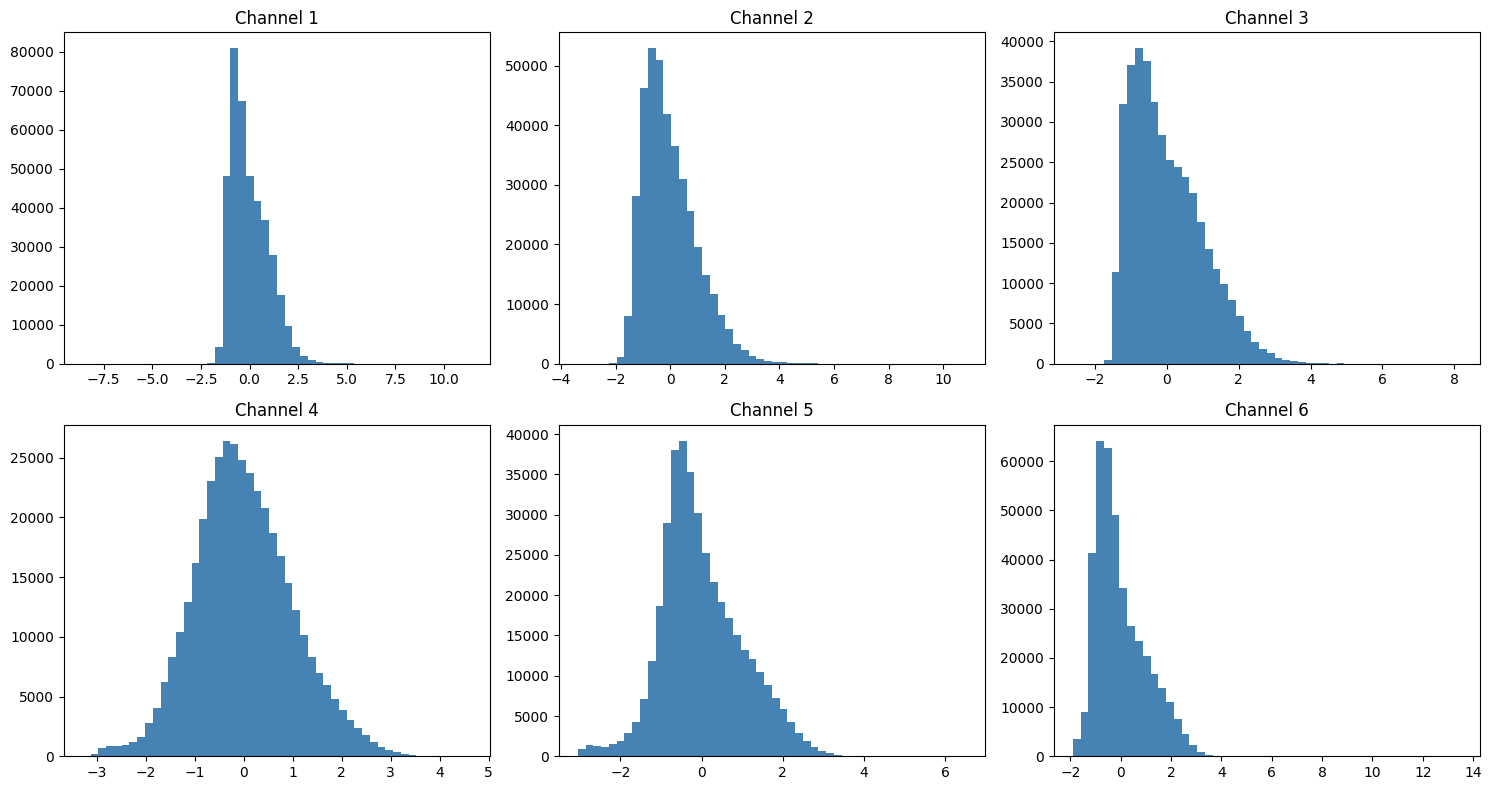



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6255      44.68%
1         1672      11.94%
2         6073      43.38%

Total samples: 14000


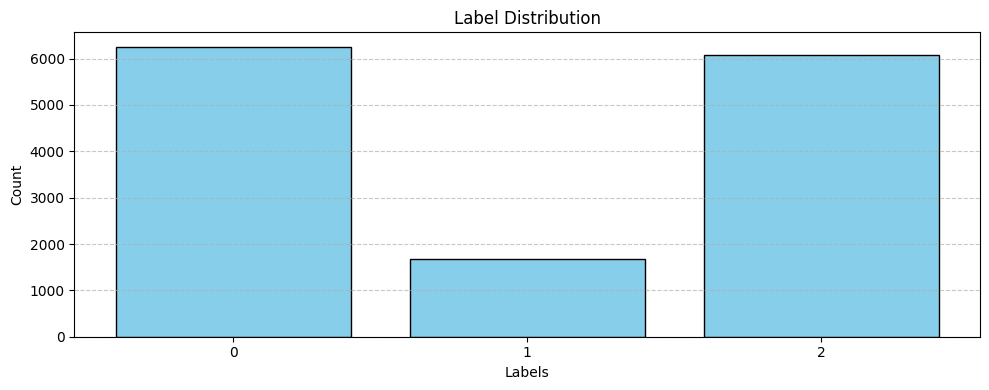


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


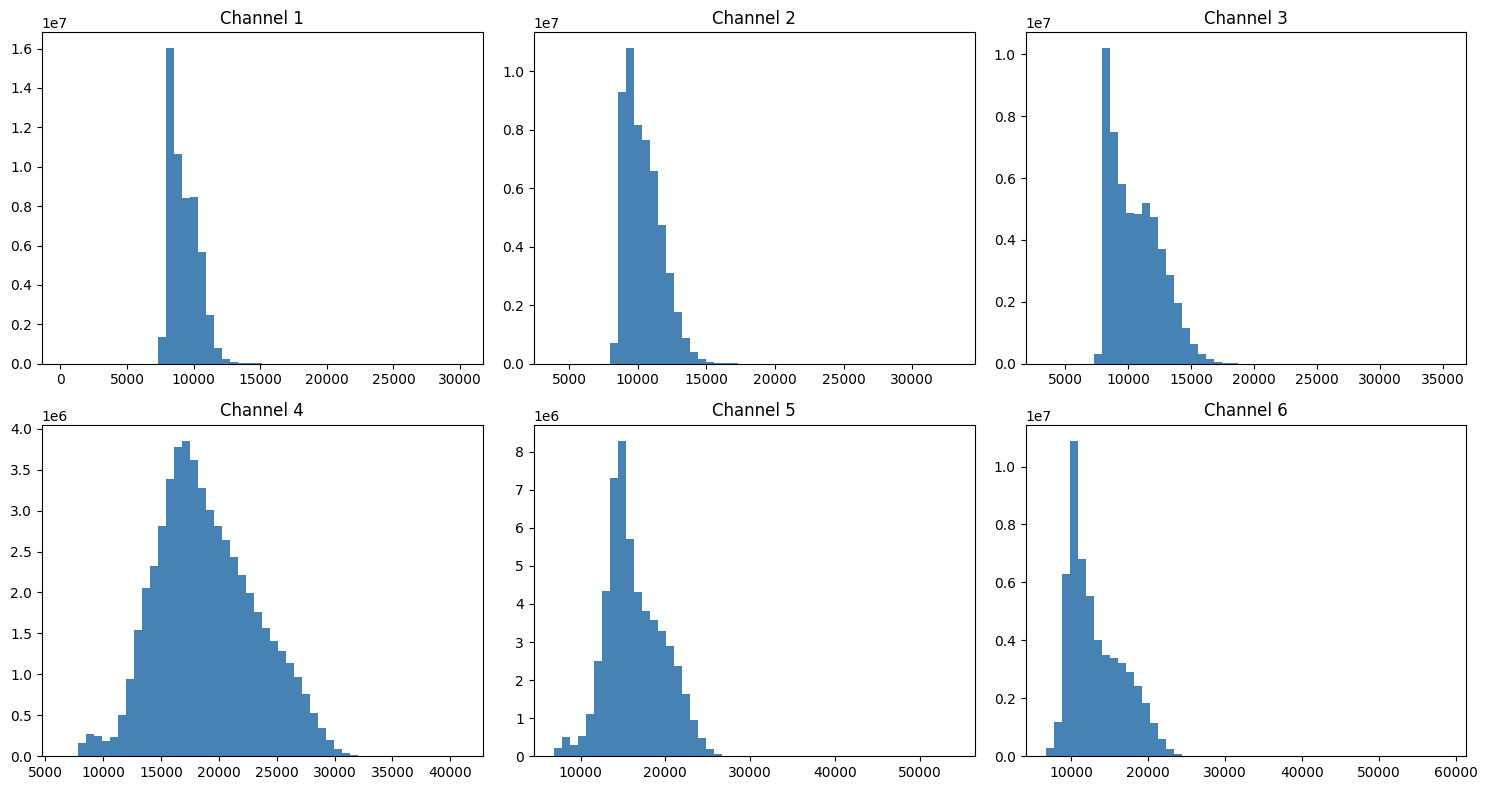

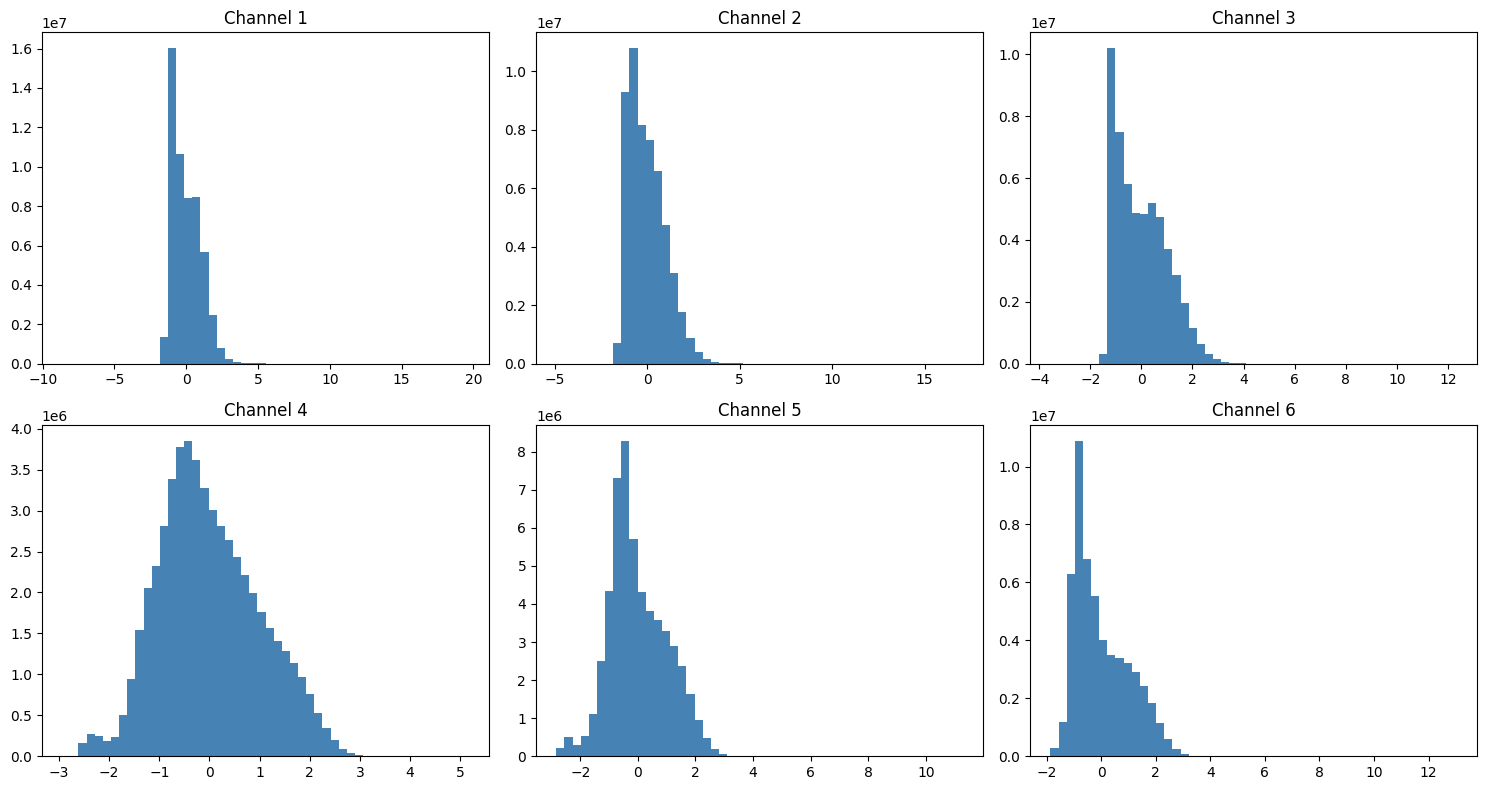



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


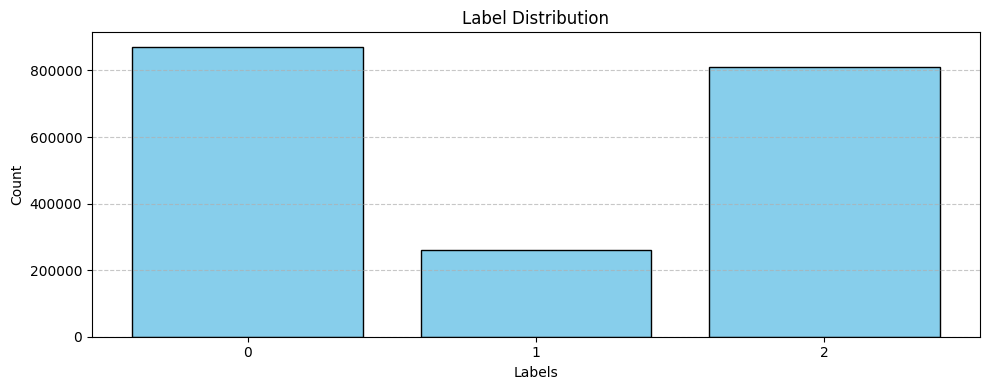

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
Class weights: tensor([0.7461, 2.7911, 0.7684], device='cuda:0')

====== Training the Model ======


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.7090 + 1e-07 * 2708809.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.84it/s]


Epoch [1/50] Train Loss: 1.4143, Train Acc: 0.4943 | Val Loss: 0.7357, Val Acc: 0.7985, F1: 0.8046, Kappa: 0.6734


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.65it/s]


Loss: 0.9349 + 1e-07 * 2536640.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.07it/s]


Epoch [2/50] Train Loss: 1.1669, Train Acc: 0.5285 | Val Loss: 0.6972, Val Acc: 0.8222, F1: 0.8221, Kappa: 0.7131


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.79it/s]


Loss: 0.7385 + 1e-07 * 2367527.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.61it/s]


Epoch [3/50] Train Loss: 1.1117, Train Acc: 0.5421 | Val Loss: 0.6541, Val Acc: 0.8471, F1: 0.8473, Kappa: 0.7511


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.75it/s]


Loss: 0.6655 + 1e-07 * 2206666.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.03it/s]


Epoch [4/50] Train Loss: 1.0734, Train Acc: 0.5520 | Val Loss: 0.6349, Val Acc: 0.8526, F1: 0.8485, Kappa: 0.7613


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.73it/s]


Loss: 1.0765 + 1e-07 * 2063007.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.72it/s]


Epoch [5/50] Train Loss: 1.0327, Train Acc: 0.5566 | Val Loss: 0.6239, Val Acc: 0.8429, F1: 0.8418, Kappa: 0.7450


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.75it/s]


Loss: 0.8760 + 1e-07 * 1934167.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.02it/s]


Epoch [6/50] Train Loss: 1.0176, Train Acc: 0.5535 | Val Loss: 0.5784, Val Acc: 0.8616, F1: 0.8568, Kappa: 0.7761


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.7953 + 1e-07 * 1816807.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.90it/s]


Epoch [7/50] Train Loss: 0.9905, Train Acc: 0.5666 | Val Loss: 0.5491, Val Acc: 0.8636, F1: 0.8578, Kappa: 0.7794


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.44it/s]


Loss: 0.9525 + 1e-07 * 1713335.5


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.12it/s]


Epoch [8/50] Train Loss: 0.9773, Train Acc: 0.5697 | Val Loss: 0.5218, Val Acc: 0.8723, F1: 0.8684, Kappa: 0.7926


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.85it/s]


Loss: 0.6179 + 1e-07 * 1621771.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.36it/s]


Epoch [9/50] Train Loss: 0.9627, Train Acc: 0.5664 | Val Loss: 0.4965, Val Acc: 0.8620, F1: 0.8582, Kappa: 0.7769


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.7925 + 1e-07 * 1536995.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.80it/s]


Epoch [10/50] Train Loss: 0.9422, Train Acc: 0.5786 | Val Loss: 0.4995, Val Acc: 0.8791, F1: 0.8775, Kappa: 0.8028


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.56it/s]


Loss: 0.9356 + 1e-07 * 1461869.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 138.67it/s]


Epoch [11/50] Train Loss: 0.9387, Train Acc: 0.5689 | Val Loss: 0.4991, Val Acc: 0.8725, F1: 0.8711, Kappa: 0.7925


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.53it/s]


Loss: 1.0037 + 1e-07 * 1394991.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.90it/s]


Epoch [12/50] Train Loss: 0.9237, Train Acc: 0.5737 | Val Loss: 0.4722, Val Acc: 0.8750, F1: 0.8718, Kappa: 0.7970


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.65it/s]


Loss: 0.7325 + 1e-07 * 1336365.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.93it/s]


Epoch [13/50] Train Loss: 0.9122, Train Acc: 0.5798 | Val Loss: 0.4824, Val Acc: 0.8739, F1: 0.8706, Kappa: 0.7948


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.9542 + 1e-07 * 1281163.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.51it/s]


Epoch [14/50] Train Loss: 0.9001, Train Acc: 0.5801 | Val Loss: 0.4465, Val Acc: 0.8749, F1: 0.8700, Kappa: 0.7972


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.91it/s]


Loss: 0.7906 + 1e-07 * 1232167.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.47it/s]


Epoch [15/50] Train Loss: 0.8879, Train Acc: 0.5832 | Val Loss: 0.4564, Val Acc: 0.8825, F1: 0.8819, Kappa: 0.8081


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.7232 + 1e-07 * 1186978.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.68it/s]


Epoch [16/50] Train Loss: 0.8840, Train Acc: 0.5823 | Val Loss: 0.4803, Val Acc: 0.8787, F1: 0.8782, Kappa: 0.8018


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.75it/s]


Loss: 1.0030 + 1e-07 * 1148732.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.56it/s]


Epoch [17/50] Train Loss: 0.8742, Train Acc: 0.5866 | Val Loss: 0.4350, Val Acc: 0.8826, F1: 0.8806, Kappa: 0.8088


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.47it/s]


Loss: 0.8231 + 1e-07 * 1112129.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.00it/s]


Epoch [18/50] Train Loss: 0.8640, Train Acc: 0.5921 | Val Loss: 0.4219, Val Acc: 0.8698, F1: 0.8632, Kappa: 0.7900


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.6460 + 1e-07 * 1079928.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.81it/s]


Epoch [19/50] Train Loss: 0.8586, Train Acc: 0.5880 | Val Loss: 0.4062, Val Acc: 0.8774, F1: 0.8712, Kappa: 0.8012


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.73it/s]


Loss: 0.9214 + 1e-07 * 1050373.0


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.33it/s]


Epoch [20/50] Train Loss: 0.8550, Train Acc: 0.5934 | Val Loss: 0.4081, Val Acc: 0.8599, F1: 0.8594, Kappa: 0.7730


Training Epoch 21: 100%|██████████| 219/219 [00:05<00:00, 42.69it/s]


Loss: 0.7990 + 1e-07 * 1022528.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.72it/s]


Epoch [21/50] Train Loss: 0.8423, Train Acc: 0.6011 | Val Loss: 0.4128, Val Acc: 0.8938, F1: 0.8927, Kappa: 0.8264


Training Epoch 22: 100%|██████████| 219/219 [00:05<00:00, 42.50it/s]


Loss: 0.6655 + 1e-07 * 999836.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.60it/s]


Epoch [22/50] Train Loss: 0.8491, Train Acc: 0.6000 | Val Loss: 0.4172, Val Acc: 0.8777, F1: 0.8752, Kappa: 0.8010


Training Epoch 23: 100%|██████████| 219/219 [00:05<00:00, 42.81it/s]


Loss: 0.8092 + 1e-07 * 976487.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.19it/s]


Epoch [23/50] Train Loss: 0.8412, Train Acc: 0.6032 | Val Loss: 0.4213, Val Acc: 0.8845, F1: 0.8837, Kappa: 0.8112


Training Epoch 24: 100%|██████████| 219/219 [00:05<00:00, 42.57it/s]


Loss: 0.7215 + 1e-07 * 954761.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.47it/s]


Epoch [24/50] Train Loss: 0.8380, Train Acc: 0.6036 | Val Loss: 0.3977, Val Acc: 0.8862, F1: 0.8841, Kappa: 0.8146


Training Epoch 25: 100%|██████████| 219/219 [00:05<00:00, 42.65it/s]


Loss: 0.6672 + 1e-07 * 934796.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.89it/s]


Epoch [25/50] Train Loss: 0.8359, Train Acc: 0.5991 | Val Loss: 0.4087, Val Acc: 0.8857, F1: 0.8839, Kappa: 0.8138


Training Epoch 26: 100%|██████████| 219/219 [00:05<00:00, 42.88it/s]


Loss: 0.6739 + 1e-07 * 915104.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.82it/s]


Epoch [26/50] Train Loss: 0.8330, Train Acc: 0.5981 | Val Loss: 0.4095, Val Acc: 0.8924, F1: 0.8910, Kappa: 0.8239


Training Epoch 27: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.8394 + 1e-07 * 896582.9375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.40it/s]


Epoch [27/50] Train Loss: 0.8303, Train Acc: 0.6006 | Val Loss: 0.3963, Val Acc: 0.8813, F1: 0.8763, Kappa: 0.8071


Training Epoch 28: 100%|██████████| 219/219 [00:05<00:00, 42.62it/s]


Loss: 0.6579 + 1e-07 * 880528.875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.72it/s]


Epoch [28/50] Train Loss: 0.8209, Train Acc: 0.5979 | Val Loss: 0.4084, Val Acc: 0.8759, F1: 0.8715, Kappa: 0.7981


Training Epoch 29: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.7584 + 1e-07 * 866531.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.78it/s]


Epoch [29/50] Train Loss: 0.8251, Train Acc: 0.5992 | Val Loss: 0.3961, Val Acc: 0.8840, F1: 0.8803, Kappa: 0.8113


Training Epoch 30: 100%|██████████| 219/219 [00:05<00:00, 42.45it/s]


Loss: 0.6633 + 1e-07 * 852413.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.80it/s]


Epoch [30/50] Train Loss: 0.8158, Train Acc: 0.6044 | Val Loss: 0.3829, Val Acc: 0.8896, F1: 0.8865, Kappa: 0.8202


Training Epoch 31: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.7251 + 1e-07 * 838987.4375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.00it/s]


Epoch [31/50] Train Loss: 0.8124, Train Acc: 0.6020 | Val Loss: 0.3818, Val Acc: 0.8860, F1: 0.8817, Kappa: 0.8146


Training Epoch 32: 100%|██████████| 219/219 [00:05<00:00, 42.57it/s]


Loss: 0.7970 + 1e-07 * 827105.75


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.12it/s]


Epoch [32/50] Train Loss: 0.8047, Train Acc: 0.6124 | Val Loss: 0.3763, Val Acc: 0.8828, F1: 0.8800, Kappa: 0.8095


Training Epoch 33: 100%|██████████| 219/219 [00:05<00:00, 42.78it/s]


Loss: 1.0039 + 1e-07 * 815850.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.51it/s]


Epoch [33/50] Train Loss: 0.8124, Train Acc: 0.6076 | Val Loss: 0.3827, Val Acc: 0.8783, F1: 0.8816, Kappa: 0.8013


Training Epoch 34: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.6580 + 1e-07 * 804437.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.09it/s]


Epoch [34/50] Train Loss: 0.7993, Train Acc: 0.6116 | Val Loss: 0.3788, Val Acc: 0.8790, F1: 0.8751, Kappa: 0.8035


Training Epoch 35: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.6649 + 1e-07 * 795850.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.12it/s]


Epoch [35/50] Train Loss: 0.8006, Train Acc: 0.6142 | Val Loss: 0.3624, Val Acc: 0.8925, F1: 0.8930, Kappa: 0.8241


Training Epoch 36: 100%|██████████| 219/219 [00:05<00:00, 42.07it/s]


Loss: 0.7962 + 1e-07 * 787506.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 132.13it/s]


Epoch [36/50] Train Loss: 0.7903, Train Acc: 0.6154 | Val Loss: 0.3746, Val Acc: 0.8949, F1: 0.8943, Kappa: 0.8278


Training Epoch 37: 100%|██████████| 219/219 [00:05<00:00, 42.14it/s]


Loss: 0.7809 + 1e-07 * 779626.625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.01it/s]


Epoch [37/50] Train Loss: 0.7883, Train Acc: 0.6177 | Val Loss: 0.3593, Val Acc: 0.8875, F1: 0.8846, Kappa: 0.8168


Training Epoch 38: 100%|██████████| 219/219 [00:05<00:00, 42.23it/s]


Loss: 0.8422 + 1e-07 * 772219.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.41it/s]


Epoch [38/50] Train Loss: 0.7966, Train Acc: 0.6145 | Val Loss: 0.3655, Val Acc: 0.8858, F1: 0.8823, Kappa: 0.8142


Training Epoch 39: 100%|██████████| 219/219 [00:05<00:00, 42.25it/s]


Loss: 0.6519 + 1e-07 * 765008.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.01it/s]


Epoch [39/50] Train Loss: 0.7910, Train Acc: 0.6164 | Val Loss: 0.4004, Val Acc: 0.8643, F1: 0.8627, Kappa: 0.7793


Training Epoch 40: 100%|██████████| 219/219 [00:05<00:00, 42.37it/s]


Loss: 0.8435 + 1e-07 * 758447.0625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.54it/s]


Epoch [40/50] Train Loss: 0.7844, Train Acc: 0.6129 | Val Loss: 0.3671, Val Acc: 0.8901, F1: 0.8883, Kappa: 0.8206


Training Epoch 41: 100%|██████████| 219/219 [00:05<00:00, 42.47it/s]


Loss: 0.7043 + 1e-07 * 752724.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.31it/s]


Epoch [41/50] Train Loss: 0.7779, Train Acc: 0.6219 | Val Loss: 0.3488, Val Acc: 0.8878, F1: 0.8836, Kappa: 0.8176


Training Epoch 42: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.5384 + 1e-07 * 747656.3125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.64it/s]


Epoch [42/50] Train Loss: 0.7808, Train Acc: 0.6271 | Val Loss: 0.3496, Val Acc: 0.8881, F1: 0.8839, Kappa: 0.8179


Training Epoch 43: 100%|██████████| 219/219 [00:05<00:00, 42.35it/s]


Loss: 0.6452 + 1e-07 * 741816.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 136.70it/s]


Epoch [43/50] Train Loss: 0.7836, Train Acc: 0.6139 | Val Loss: 0.3606, Val Acc: 0.8888, F1: 0.8875, Kappa: 0.8185


Training Epoch 44: 100%|██████████| 219/219 [00:05<00:00, 42.38it/s]


Loss: 0.7743 + 1e-07 * 736260.5625


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.60it/s]


Epoch [44/50] Train Loss: 0.7825, Train Acc: 0.6240 | Val Loss: 0.3739, Val Acc: 0.8799, F1: 0.8759, Kappa: 0.8052


Training Epoch 45: 100%|██████████| 219/219 [00:05<00:00, 42.37it/s]


Loss: 0.9252 + 1e-07 * 732737.25


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.80it/s]


Epoch [45/50] Train Loss: 0.7829, Train Acc: 0.6204 | Val Loss: 0.3542, Val Acc: 0.8762, F1: 0.8722, Kappa: 0.7996


Training Epoch 46: 100%|██████████| 219/219 [00:05<00:00, 42.51it/s]


Loss: 0.6949 + 1e-07 * 727699.125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 133.53it/s]


Epoch [46/50] Train Loss: 0.7704, Train Acc: 0.6235 | Val Loss: 0.3531, Val Acc: 0.8844, F1: 0.8816, Kappa: 0.8115


Training Epoch 47: 100%|██████████| 219/219 [00:05<00:00, 42.61it/s]


Loss: 0.7549 + 1e-07 * 722618.6875


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 134.44it/s]


Epoch [47/50] Train Loss: 0.7765, Train Acc: 0.6217 | Val Loss: 0.3537, Val Acc: 0.8903, F1: 0.8893, Kappa: 0.8210


Training Epoch 48: 100%|██████████| 219/219 [00:05<00:00, 42.41it/s]


Loss: 0.9769 + 1e-07 * 716933.375


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.01it/s]


Epoch [48/50] Train Loss: 0.7719, Train Acc: 0.6307 | Val Loss: 0.3483, Val Acc: 0.8908, F1: 0.8891, Kappa: 0.8219


Training Epoch 49: 100%|██████████| 219/219 [00:05<00:00, 42.44it/s]


Loss: 0.7232 + 1e-07 * 711884.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 137.14it/s]


Epoch [49/50] Train Loss: 0.7620, Train Acc: 0.6346 | Val Loss: 0.3479, Val Acc: 0.8910, F1: 0.8868, Kappa: 0.8227


Training Epoch 50: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.6607 + 1e-07 * 707455.8125


Stochastic Validation (T=10): 100%|██████████| 152/152 [00:01<00:00, 135.44it/s]


Epoch [50/50] Train Loss: 0.7584, Train Acc: 0.6317 | Val Loss: 0.3417, Val Acc: 0.8869, F1: 0.8829, Kappa: 0.8159


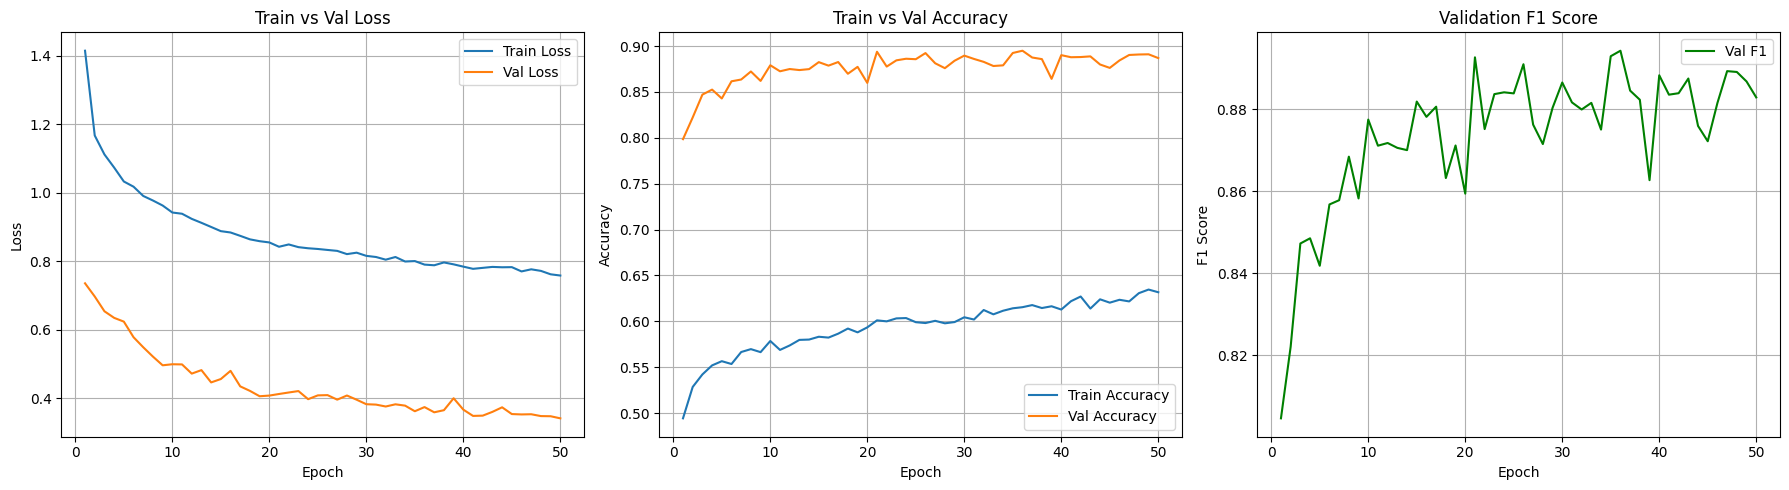


====== Testing the Model ======


Stochastic Validation (T=10): 100%|██████████| 30219/30219 [03:42<00:00, 135.78it/s]



====== Test Results ======
Overall Loss: 0.3402
Overall Accuracy: 0.8888
Cohen's Kappa: 0.8188
Per Class F1: [0.89192793 0.87580715 0.89003814]
Macro (Avg) F1: 0.8859


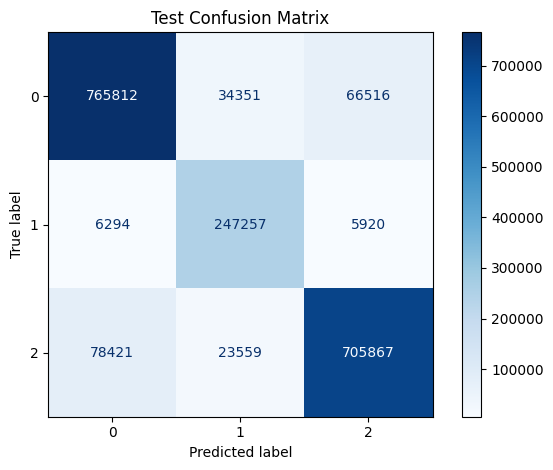

History Dumped in file /kaggle/working/true_BCNN_data_variation_ratio_history.json
Saved history of all files to true_BCNN_training_evaluation.xlsx


In [18]:
for name in file_names:
    print(f'\n\n====== Loading Data {name} ======')
    X_train, y_train = load_data(name)

    if X_train.shape[1:] == (6,28):
        X_train = X_train.transpose(0,2,1)
        
    print('Train Data: ', X_train.shape, y_train.shape)
    plot_input_dist(X_train)
    X_train = normalize(X_train)
    plot_input_dist(X_train)
    plot_label_dist(y_train)

    print(f'\n====== Loading Data Site {SITE} - {YEAR} ======')
    X_B2020, y_B2020 = load_data(X_B2020_path, y_B2020_path)
    print(f'Site {SITE} - {YEAR} Data: {X_B2020.shape}, {y_B2020.shape}')
    plot_input_dist(X_B2020)
    X_B2020 = normalize(X_B2020)
    plot_input_dist(X_B2020)
    plot_label_dist(y_B2020)

    # Data Split
    X_test, X_val, y_test, y_val = train_test_split(X_B2020, y_B2020, test_size=0.005, stratify=y_B2020, random_state=42)
    print(f'Val Data: ', X_val.shape, y_val.shape)
    print(f'Test Data: ', X_test.shape, y_test.shape)

    # Creating datasets and dataloaders
    train_dataset = Conv1dDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = Conv1dDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = Conv1dDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model Initialization
    model = BayesianCNN_FC(priors=PRIORS, num_classes=3, device=DEVICE).to(DEVICE)
    ckpt = torch.load('/kaggle/input/b_cnn/pytorch/default/1/BCNN.pth', map_location='cpu')
    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        state = ckpt['model_state_dict']
    else:
        state = ckpt
    
    new_state = {}
    for k, v in state.items():
        if k.startswith("_orig_mod."):
            new_state[k.replace("_orig_mod.", "")] = v
        else:
            new_state[k] = v
    model.load_state_dict(new_state, strict=True)

    # ===== Class weights =====
    all_labels = []
    for _, y_batch in train_dataloader:
        all_labels.append(y_batch.numpy())
    
    all_labels = np.concatenate(all_labels)
    classes = np.unique(all_labels)
    class_weights_np = compute_class_weight(class_weight='balanced',
                                            classes=classes, y=all_labels)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
    print("Class weights:", class_weights)

    print(f'\n====== Training the Model ======')
    train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s = train(model, train_dataset, train_dataloader, val_dataset, val_dataloader, class_weights, EPOCHS=EPOCHS, T=T)
    plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS)

    print(f'\n====== Testing the Model ======')
    loss, acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, class_weights=class_weights, T=T, device=DEVICE)

    # Printing
    print(f'\n====== Test Results ======')
    print(f'Overall Loss: {loss:.4f}')
    print(f'Overall Accuracy: {acc:.4f}')
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f'Per Class F1: {per_class_f1}')
    print(f"Macro (Avg) F1: {avg_f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Test Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Logging History
    history[name]['train_loss'] = train_losses
    history[name]['train_acc'] = train_accs
    history[name]['val_loss'] = val_losses
    history[name]['val_acc'] = val_accs
    history[name]['val_f1s'] = val_f1s
    history[name]['val_kappas'] = val_kappas
    history[name]['val_per_class_f1s'] = val_per_class_f1s
    
    history[name]['overall_loss'] = float(loss)
    history[name]['overall_acc'] = float(acc)
    history[name]['kappa'] = float(kappa)
    history[name]['per_class_f1'] = per_class_f1.tolist() if isinstance(per_class_f1, (np.ndarray, list)) else per_class_f1
    history[name]['avg_f1'] = float(avg_f1)
    history[name]['cm'] = cm.tolist() if hasattr(cm, "tolist") else cm

    # Dumping
    save_history(history[name], name)

    
# Saving the Results
save_results('true_BCNN_training_evaluation', history)

<hr>